# **import Libraries**

In [119]:
import numpy as np
import pandas as pd
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import ttest_ind
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **download data**

In [120]:
df=pd.read_csv('creditcard.csv')

Data Preprocessing

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [122]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


# **feature engineering**

In [123]:
# I used the T-test to compare the feature distributions between the two classes, and any feature with p-value below 0.05,
# I considered it statistically significant and possibly useful for the model

# عملته لكل الفيتشرز عشان اشوف اذا في فرق بين الاحتيال وغير الاحتيال واعتبرت الفيتشرز الي الهم p_val<0.05 مؤثره ومهمه


   Feature_Name  T_Statistic        P_Value  Is_Significant_Less_Than_0.05
14          V14   -36.201024  1.040151e-140                           True
4            V4    35.116449  4.587317e-136                           True
11          V11    31.519223  4.577212e-120                           True
12          V12   -29.880026  1.481317e-112                           True
10          V10   -25.755260   3.382884e-93                           True
16          V16   -23.798892   7.905326e-84                           True
9            V9   -22.928481   1.193505e-79                           True
3            V3   -21.976004   4.786081e-75                           True
17          V17   -21.247727   1.558094e-71                           True
2            V2    18.761177   1.288580e-59                           True
18          V18   -17.213506   2.639223e-52                           True
7            V7   -17.168755   4.292231e-52                           True
6            V6   -16.706

<ipython-input-124-cc3070ec13b6>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Class', palette='Set2')


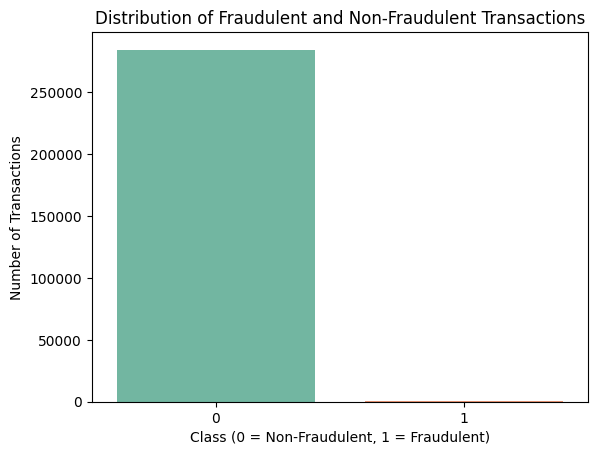

In [124]:
features=df.columns.drop(['Class'])
fraud= df[df['Class'] == 1]
normal= df[df['Class'] == 0]
ttest_results = pd.DataFrame([
    {
        'Feature_Name': feature_name,
        'T_Statistic': t_statistic,
        'P_Value': p_value,
        'Is_Significant_Less_Than_0.05': p_value < 0.05
    }
    for feature_name in features
    for t_statistic, p_value in [ttest_ind(fraud[feature_name],normal[feature_name], equal_var=False)]
])
print(ttest_results.sort_values('P_Value'))
# Plot the distribution of fraud and non-fraud transactions
sns.countplot(data=df, x='Class', palette='Set2')
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.xlabel('Class (0 = Non-Fraudulent, 1 = Fraudulent)')
plt.ylabel('Number of Transactions')
plt.show()


In [127]:
#أنا اشتغلت على استخراج شوية فيتشرز من الوقت والمبلغ، يعني مثل إذا العملية صارت بالليل، أو نسبة المبلغ لمتوسط المبالغ،
 #وكمان جمّعت العمليات حسب كل ساعة. الهدف إني أساعد النموذج يميّز بين العمليات الاحتيالية والطبيعية بشكل أذكى

# I created features from the time and amount fields, like checking if the transaction was at night or comparing the amount to the average
#  I also grouped the data hourly to spot any unusual patterns — all of this was to improve the model’s ability to catch fraud.





In [125]:
start_date=pd.to_datetime("2010-1-1")
df['Datetime']=pd.to_datetime(start_date + pd.to_timedelta(df['Time'], unit='s'))
df['Minute'] = df['Datetime'].dt.minute
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Is_Night'] = df['Hour'].between(0, 6).astype(int)
df['Log_Amount'] = np.log1p(df['Amount'])
mean_amount = df['Amount'].mean()
margin = 0.1 * mean_amount
def classify_amount(value):
    if value >= mean_amount + margin:
        return 2
    elif value <= mean_amount - margin:
        return 0
    else:
        return 1
df['Amount_Level'] = df['Amount'].apply(classify_amount)
df = df.sort_values(by='Time')
df['Time_Diff'] = df['Time'].diff().fillna(0)
df['Amount_to_Mean_Ratio'] = df['Amount'] / mean_amount
df['Datetime_rounded'] = df['Datetime'].dt.floor('H')
agg_features = df.groupby('Datetime_rounded')['Amount'].agg(['mean', 'sum', 'count']).reset_index()
agg_features.rename(columns={'mean': 'Amount_mean_1h', 'sum': 'Amount_sum_1h', 'count': 'Count_1h'}, inplace=True)
df = df.merge(agg_features, how='left', on='Datetime_rounded')
df['LogAmount_x_Hour'] = df['Log_Amount'] * df['Hour']
df['Amount_x_IsNight'] = df['Amount'] * df['Is_Night']
df.drop(['Datetime_rounded'], axis=1, inplace=True)
print(df.head())

<ipython-input-125-749cd87b0ed7>:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Datetime_rounded'] = df['Datetime'].dt.floor('H')


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...  Is_Night  Log_Amount  Amount_Level  Time_Diff  \
0  0.098698  0.363787  ...         1    5.014760             2        0.0   
1  0.085102 -0.255425  ...         1    1.305626             0        0.0   
2  0.247676 -1.514654  ...         1    5.939276             2        1.0   
3  0.377436 -1.387024  ...         1    4.824306             2        0.0   
4 -0.270533  0.817739  ...         1    4.262539             0        1.0   

   Amount_to_Mean_Ratio  Amount_mean_1h  Amount_su

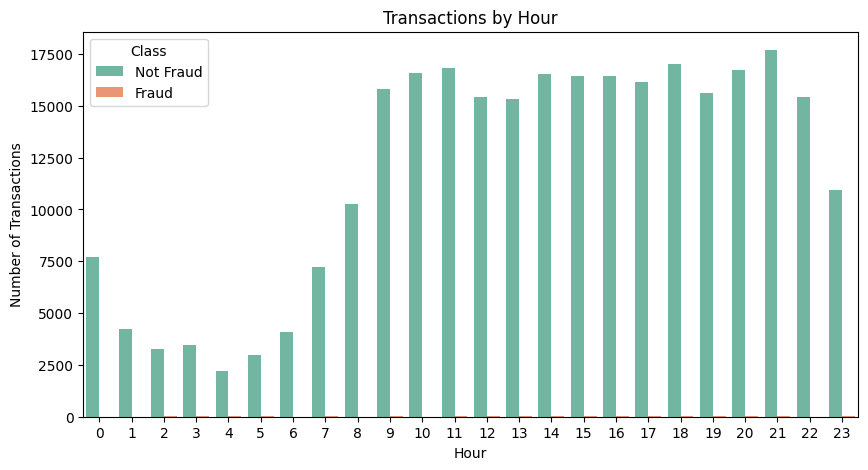

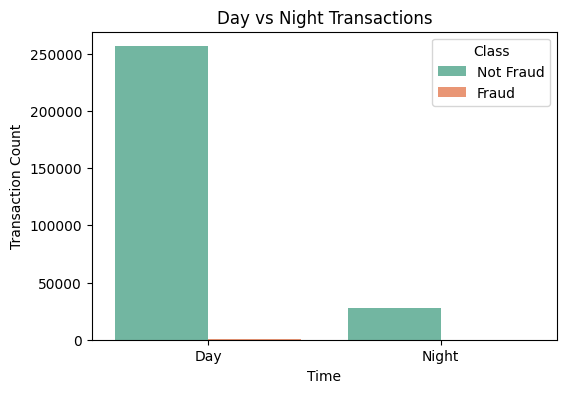

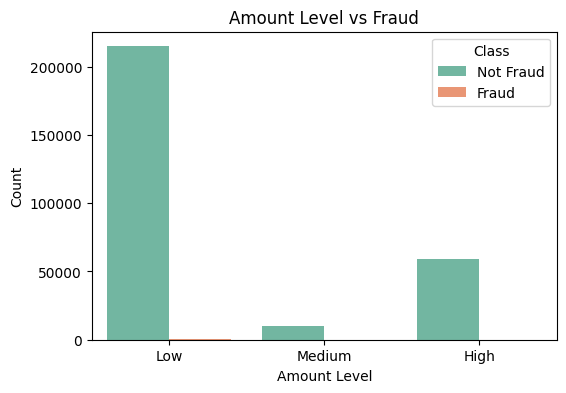

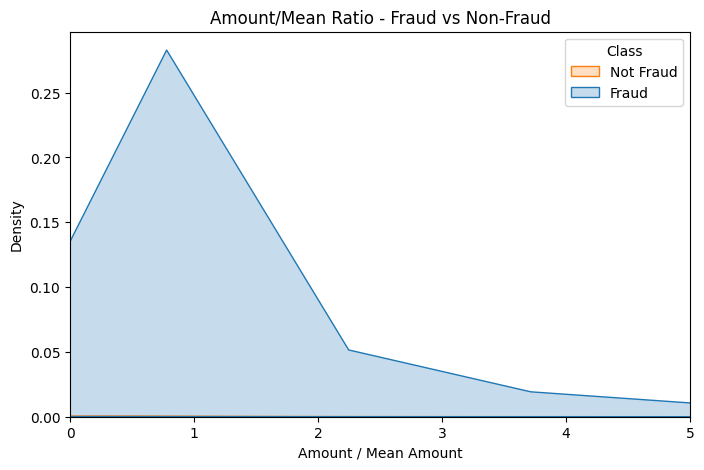

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Hour', hue='Class', palette='Set2')
plt.title('Transactions by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.legend(title='Class', labels=['Not Fraud', 'Fraud'])
plt.show()
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Is_Night', hue='Class', palette='Set2')
plt.title('Day vs Night Transactions')
plt.xticks([0, 1], ['Day', 'Night'])
plt.xlabel('Time')
plt.ylabel('Transaction Count')
plt.legend(title='Class', labels=['Not Fraud', 'Fraud'])
plt.show()
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Amount_Level', hue='Class', palette='Set2')
plt.title('Amount Level vs Fraud')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.xlabel('Amount Level')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Not Fraud', 'Fraud'])
plt.show()
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='Amount_to_Mean_Ratio', hue='Class', fill=True)
plt.title('Amount/Mean Ratio - Fraud vs Non-Fraud')
plt.xlabel('Amount / Mean Amount')
plt.ylabel('Density')
plt.legend(title='Class', labels=['Not Fraud', 'Fraud'])
plt.xlim(0,5)
plt.show()

# **Data preprocessing**

In [128]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...  Is_Night  Log_Amount  Amount_Level  Time_Diff  \
0  0.098698  0.363787  ...         1    5.014760             2        0.0   
1  0.085102 -0.255425  ...         1    1.305626             0        0.0   
2  0.247676 -1.514654  ...         1    5.939276             2        1.0   
3  0.377436 -1.387024  ...         1    4.824306             2        0.0   
4 -0.270533  0.817739  ...         1    4.262539             0        1.0   

   Amount_to_Mean_Ratio  Amount_mean_1h  Amount_sum_1h  Count_1h  \
0              1.693499       64.875566      257101.87      3963   
1              0.030447       64.875566      257101.87      3963   
2              4.285927       64.875566      257101.87      3963   
3              1.397855       64.875566      257101.87      3963   
4              0.792194       64.875566      257101.87      3963   

   LogAmount_x_Hour  Amount_x_IsNight  
0               0.0            149.62  
1               0.0              2.69  
2               0.0            378.66  
3               0.0            123.50  
4               0.0             69.99  

[5 rows x 47 columns]

In [129]:
df.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165581e-15  3.321107e-16 -1.392310e-15  2.100440e-15   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.723818e-16  1.516852e-15 -5.576426e-16  1.160591e-16 -2.419079e-15   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   

       ...       Is_Night     Log_Amount   Amount_Level      Time_Diff  \
count  ...  284807.000000  284807.000000  284807.000000  284807.000000   
mean   ...       0.098435       3.152188       0.452977       0.606699   
min    ...       0.000000       0.000000       0.000000       0.000000   
25%    ...       0.000000       1.887070       0.000000       0.000000   
50%    ...       0.000000       3.135494       0.000000       0.000000   
75%    ...       0.000000       4.358822       0.000000       1.000000   
max    ...       1.000000      10.153941       2.000000      32.000000   
std    ...       0.297903       1.656648       0.815286       1.053380   

       Amount_to_Mean_Ratio  Amount_mean_1h  Amount_sum_1h       Count_1h  \
count         284807.000000   284807.000000  284807.000000  284807.000000   
mean               1.000000       88.349619  662730.922631    7293.955665   
min                0.000000       45.880976   74394.260000    1082.000000   
25%                0.063385       74.369443  562167.070000    7655.000000   
50%                0.249011       91.189312  735885.640000    7882.000000   
75%                0.873405      104.509441  856698.420000    8432.000000   
max              290.789708      113.524569  966888.750000    9895.000000   
std                2.831026       17.573351  237967.618734    2024.743737   

       LogAmount_x_Hour  Amount_x_IsNight  
count     284807.000000     284807.000000  
mean          44.041199          6.083833  
min            0.000000          0.000000  
25%           18.871579          0.000000  
50%           40.681306          0.000000  
75%           63.236530          0.000000  
max          223.386706      18910.000000  
std           30.272683         69.167868  

[8 rows x 47 columns]

In [130]:
df.isnull().sum()

Time                    0
V1                      0
V2                      0
V3                      0
V4                      0
V5                      0
V6                      0
V7                      0
V8                      0
V9                      0
V10                     0
V11                     0
V12                     0
V13                     0
V14                     0
V15                     0
V16                     0
V17                     0
V18                     0
V19                     0
V20                     0
V21                     0
V22                     0
V23                     0
V24                     0
V25                     0
V26                     0
V27                     0
V28                     0
Amount                  0
Class                   0
Datetime                0
Minute                  0
Hour                    0
Day                     0
Month                   0
DayOfWeek               0
Is_Night                0
Log_Amount              0
Amount_Level            0
Time_Diff               0
Amount_to_Mean_Ratio    0
Amount_mean_1h          0
Amount_sum_1h           0
Count_1h                0
LogAmount_x_Hour        0
Amount_x_IsNight        0
dtype: int64

# **data balancing**

In [131]:
# There was a big difference in the number of samples between fraudulent and normal transactions
# so I balanced the data to prevent the model from being biased toward the majority class


# كان في فرق كبير بعدد العينات بين الاحتيال والعادي، فعملت توازن بالبيانات عشان النموذج ما ينحاز للأغلبية


In [132]:
class_0 = df[df['Class'] == 0]
class_1 = df[df['Class'] == 1]
n_class_1 = len(class_1)
class_0_sampled = class_0.sample(n=3 * n_class_1, random_state=42)
df= pd.concat([class_0_sampled, class_1], ignore_index=True)
df= df.sample(frac=1, random_state=42).reset_index(drop=True)

In [133]:
print(df['Class'].value_counts())

Class
0    1476
1     492
Name: count, dtype: int64


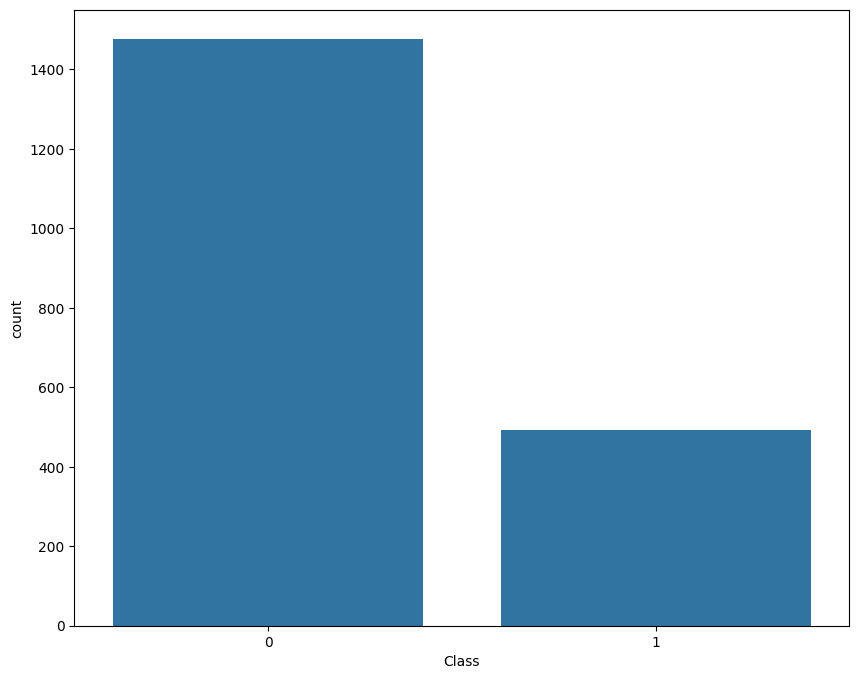

In [134]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.countplot(x='Class',data=df)
plt.show()

# **feature engineering**

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Time                  1968 non-null   float64       
 1   V1                    1968 non-null   float64       
 2   V2                    1968 non-null   float64       
 3   V3                    1968 non-null   float64       
 4   V4                    1968 non-null   float64       
 5   V5                    1968 non-null   float64       
 6   V6                    1968 non-null   float64       
 7   V7                    1968 non-null   float64       
 8   V8                    1968 non-null   float64       
 9   V9                    1968 non-null   float64       
 10  V10                   1968 non-null   float64       
 11  V11                   1968 non-null   float64       
 12  V12                   1968 non-null   float64       
 13  V13               

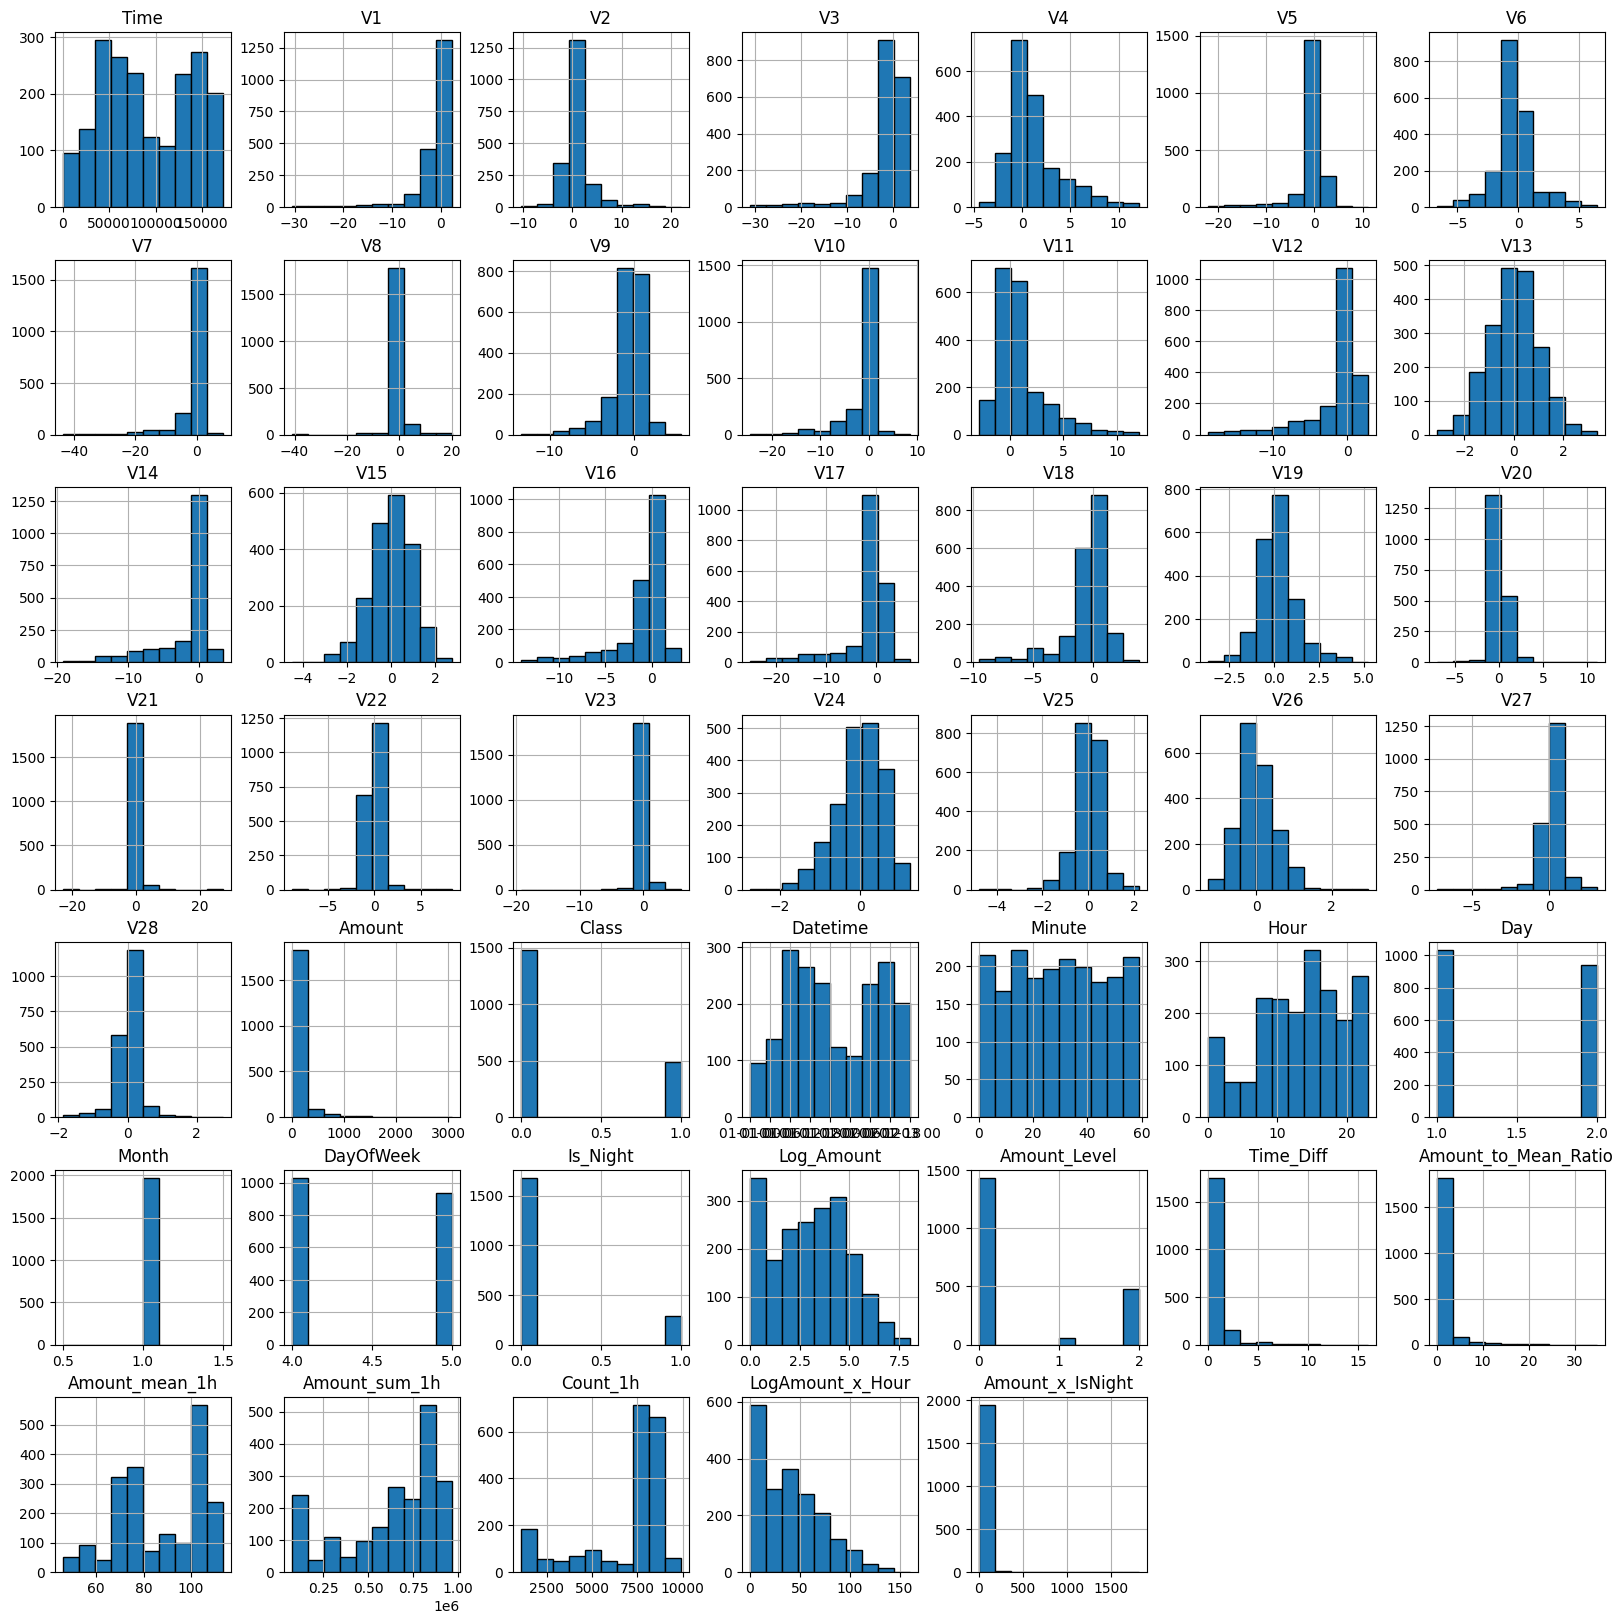

In [136]:
df.hist(figsize=(20,20),edgecolor='black')
plt.show()

In [137]:
df.head()

Time        V1        V2        V3        V4        V5        V6  \
0   80957.0 -1.600211 -0.612738  3.106870  3.304341  1.329700  2.683346   
1    7519.0  1.234235  3.019740 -4.304597  4.732795  3.624201 -1.357746   
2  132368.0 -0.759901 -0.274367 -3.383126 -0.315560  0.153328  0.375158   
3  148525.0 -0.319220  0.546393 -0.177223 -1.396883  0.328848 -0.514939   
4  166950.0  1.985762 -0.332453 -0.265697  0.487491 -0.659826 -0.511851   

         V7        V8        V9  ...  Is_Night  Log_Amount  Amount_Level  \
0 -1.386640  1.206106 -0.463393  ...         0    2.873565             0   
1  1.713445 -0.496358 -1.282858  ...         1    0.693147             0   
2  3.372009 -0.119070 -1.074708  ...         0    6.383608             2   
3  0.248034  0.114334 -1.807604  ...         0    2.341806             0   
4 -0.527851 -0.116684  1.317009  ...         0    2.396986             0   

   Time_Diff  Amount_to_Mean_Ratio  Amount_mean_1h  Amount_sum_1h  Count_1h  \
0        1.0              0.189022       69.973597      628152.98      8977   
1        5.0              0.011319       69.047697      108819.17      1576   
2        0.0              6.690012       98.908734      760410.35      7688   
3        0.0              0.106395       91.189312      755412.26      8284   
4        0.0              0.113073       69.740534      450802.81      6464   

   LogAmount_x_Hour  Amount_x_IsNight  
0         63.218422               0.0  
1          1.386294               1.0  
2         76.603296               0.0  
3         39.810699               0.0  
4         52.733687               0.0  

[5 rows x 47 columns]

# **scaling**

random forest after scaling to view the most important features
---





عملت  scaling
 بعدين طبقته على  random forest  
 عشان اعرف ال  features  الي الهم اكثر اهميه

In [138]:
# First I scaled the numeric features, then used Random Forest to see which
#  features are actually playing a big role in detecting fraud


# عملت  scaling
#  بعدين طبقته على  random forest
#  عشان اعرف ال  features  الي الهم اكثر اهميه



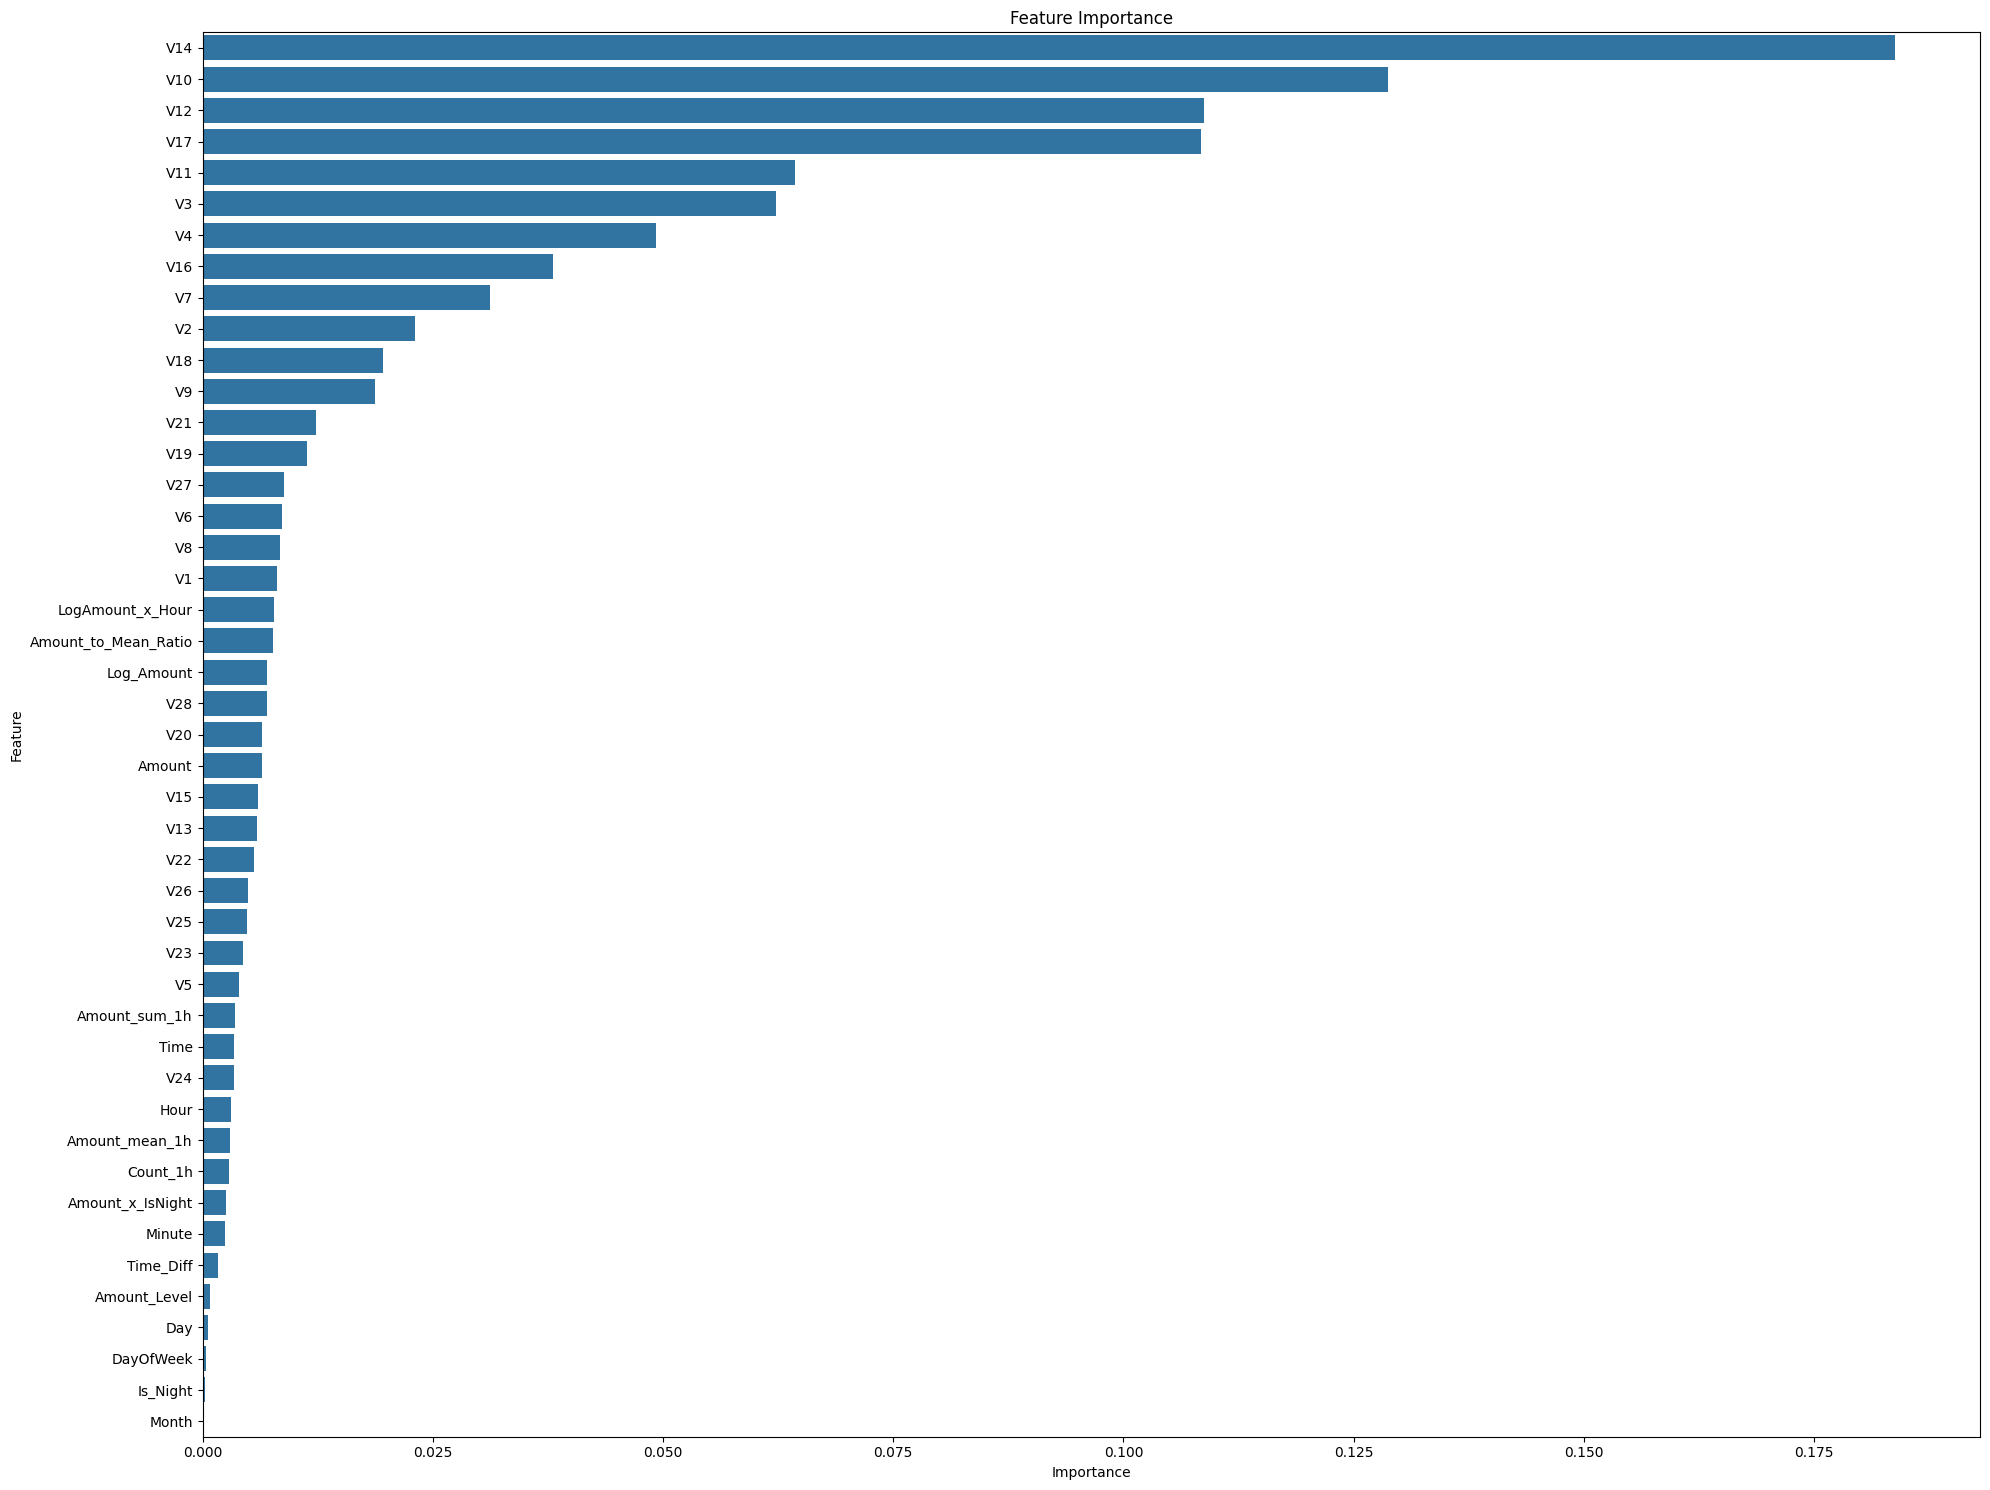

In [139]:
X_df_for_scaling = df.drop(['Class', 'Datetime'], axis=1).select_dtypes(include=[np.number])
y=df['Class']
feature_names_after_scaling = X_df_for_scaling.columns
scaler=StandardScaler()
X_scal=scaler.fit_transform(X_df_for_scaling)
model=RandomForestClassifier(random_state=42)
model.fit(X_scal,y)
importances=model.feature_importances_
features=feature_names_after_scaling
importance_df=pd.DataFrame({'Feature':features,'Importance':importances})
importance_df=importance_df.sort_values(by='Importance',ascending=False)
plt.figure(figsize=(20, 15))
sns.barplot(x='Importance',y='Feature',data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# **feature engineering**

In [140]:
# حذف الفيتشرز غير المهمات بالاعتماد على  feature importance

In [141]:
features = [
   'Is_Night', 'DayOfWeek',  'Month'
]
df = df.drop(columns=features)
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Datetime', 'Minute', 'Hour', 'Day', 'Log_Amount',
       'Amount_Level', 'Time_Diff', 'Amount_to_Mean_Ratio', 'Amount_mean_1h',
       'Amount_sum_1h', 'Count_1h', 'LogAmount_x_Hour', 'Amount_x_IsNight'],
      dtype='object')


بهالجزء طبقت Isolation Forest على الداتا الرقمية بعد ما عملتلها scaling، واستثنيت عمود الـ Class وDatetime لأنهم مش مهمين للنموذج نفسه، وخليت نسبة الـ contamination 0.05 يعني بعتبر 5% من الداتا شاذة

In [142]:
# استعملت الخوارزميه حتى انشئ فيتشر جديده "isolation forest" للكشف عن نقاط الشذوذ واستخدامهم ك فيتشر

In [143]:
numeric_columns = df.drop(['Class', 'Datetime'], axis=1).select_dtypes(include=[np.number]).columns
X_fe = df[numeric_columns]
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_fe)
anomaly_score_iso=iso.decision_function(X_fe)
X_fe['anomaly_score_iso']=anomaly_score_iso
X_fe.columns = X_fe.columns.astype(str)

<ipython-input-143-55b38d899bea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fe['anomaly_score_iso']=anomaly_score_iso


In [144]:
# Here I used One-Class SVM to calculate the anomaly score for each row and added it as a new feature
#  Then I applied KMeans clustering to the dataset to see if there are any hidden patterns or clusters that might relate to fraudulent or normal behavior

#  هون استخدمت One-Class SVM عشان أطلع درجة الشذوذ لكل صف، وضفتها كعمود جديد. بعدين طبقت KMeans بالتالي على كل الداتا، عشان أشوف إذا في أنماط أو مجموعات معينة ممكن تكون مرتبطة بالسلوك الاحتيالي أو الطبيعي.



In [145]:
ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
ocsvm.fit(X_fe)
anomaly_score_ocsvm = -ocsvm.decision_function(X_fe)
X_fe['anomaly_score_ocsvm'] = anomaly_score_ocsvm
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_fe)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [146]:
# After training the KMeans model, I calculated the distance from each row to every cluster center and added these distances as new features
#  The idea is to help the model learn based on how far a sample is from the cluster centers, since fraudulent data might be more distant or isolated.

# هون بعد ما دربت KMeans، حسبت المسافة من كل صف إلى كل سنتر من الكلاسترز، وضفت هاي المسافات كـ features جديدة. الهدف إني أساعد النموذج يتعلّم من موقع العينة بالنسبة للتجمعات، لأن ممكن البيانات الاحتيالية تكون أبعد عن المراكز.



In [147]:
distances = kmeans.transform(X_fe)
distances_df = pd.DataFrame(distances, columns=[f'dist_kmeans_{i+1}' for i in range(distances.shape[1])])
X_fe = pd.concat([X_fe.reset_index(drop=True), distances_df.reset_index(drop=True)], axis=1)

# **Feature Exploration**

In [148]:
# In this part, I used a Random Forest model after ensuring that all features were numeric
#  The goal was to identify which features were most influential in detecting fraud. The bar chart here helps visualize the most important features that could be valuable inputs for any classification model.

# بهالجزء استخدمت Random Forest بعد ما تأكدت إنو كل الفيتشرز رقمية، عشان أحدد أي الميزات كانت أكثر تأثيرًا بتمييز العمليات الاحتيالية. الرسم البياني هون بساعدني أشوف بشكل واضح أهم الفيتشرز اللي ممكن أستخدمها كمدخلات فعّالة لأي نموذج .


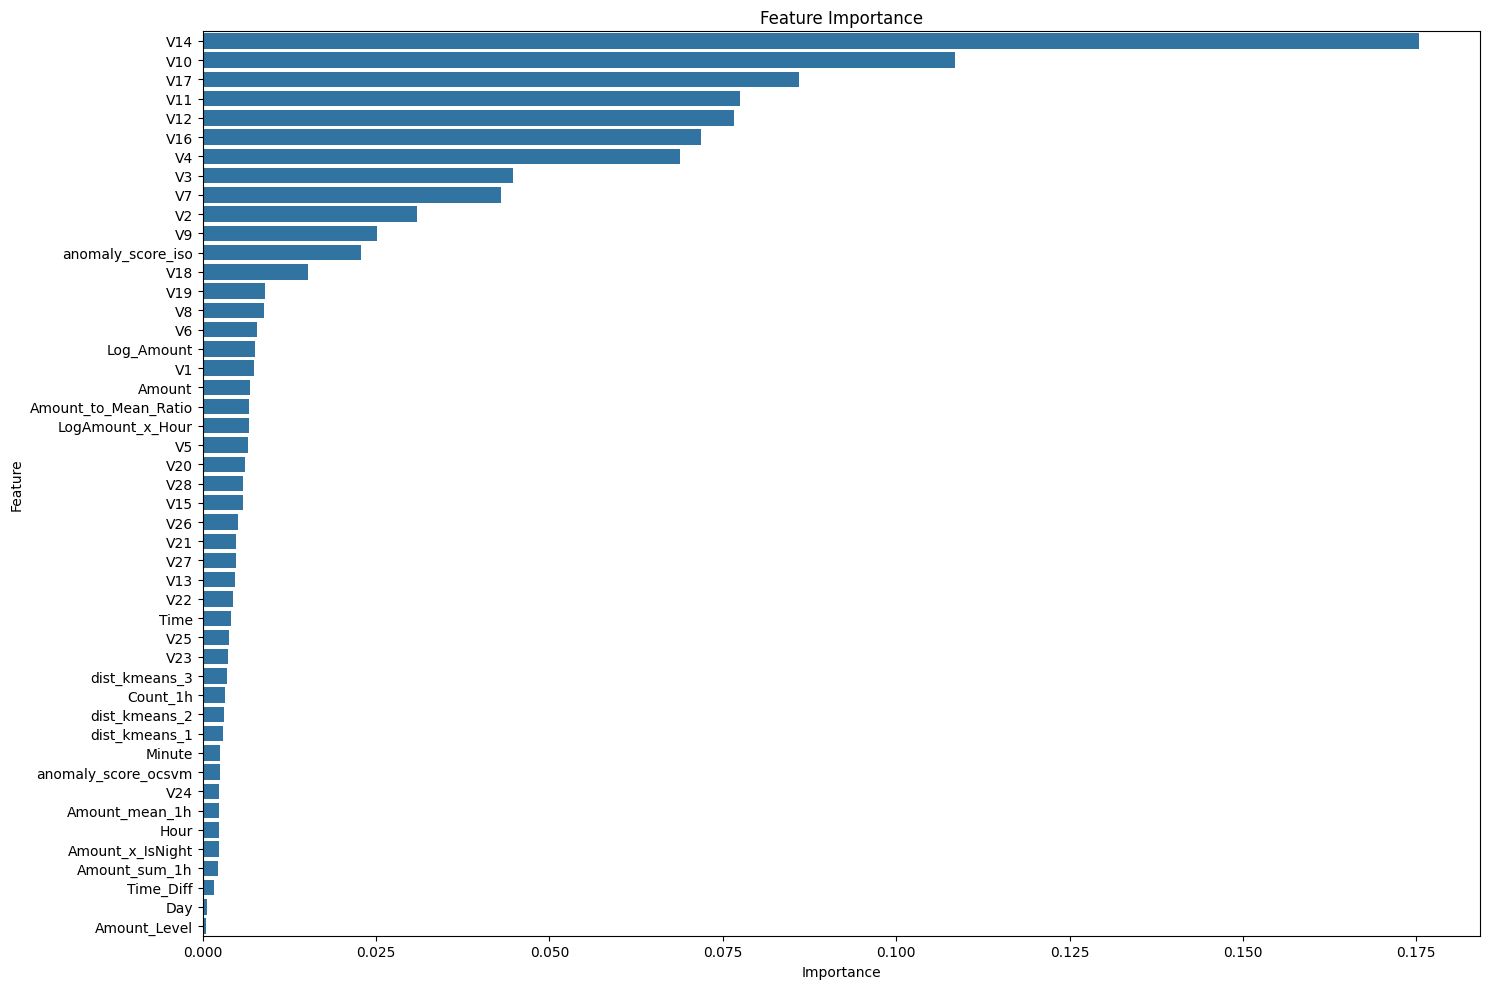

In [149]:
X_fe = X_fe.select_dtypes(include=[np.number])
y = df['Class']
model = RandomForestClassifier(random_state=42)
model.fit(X_fe, y)
importances = model.feature_importances_
features = X_fe.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [150]:
X = df.select_dtypes(include=[np.number])
y = df['Class']
scaler = StandardScaler()
X_scal= scaler.fit_transform(X)

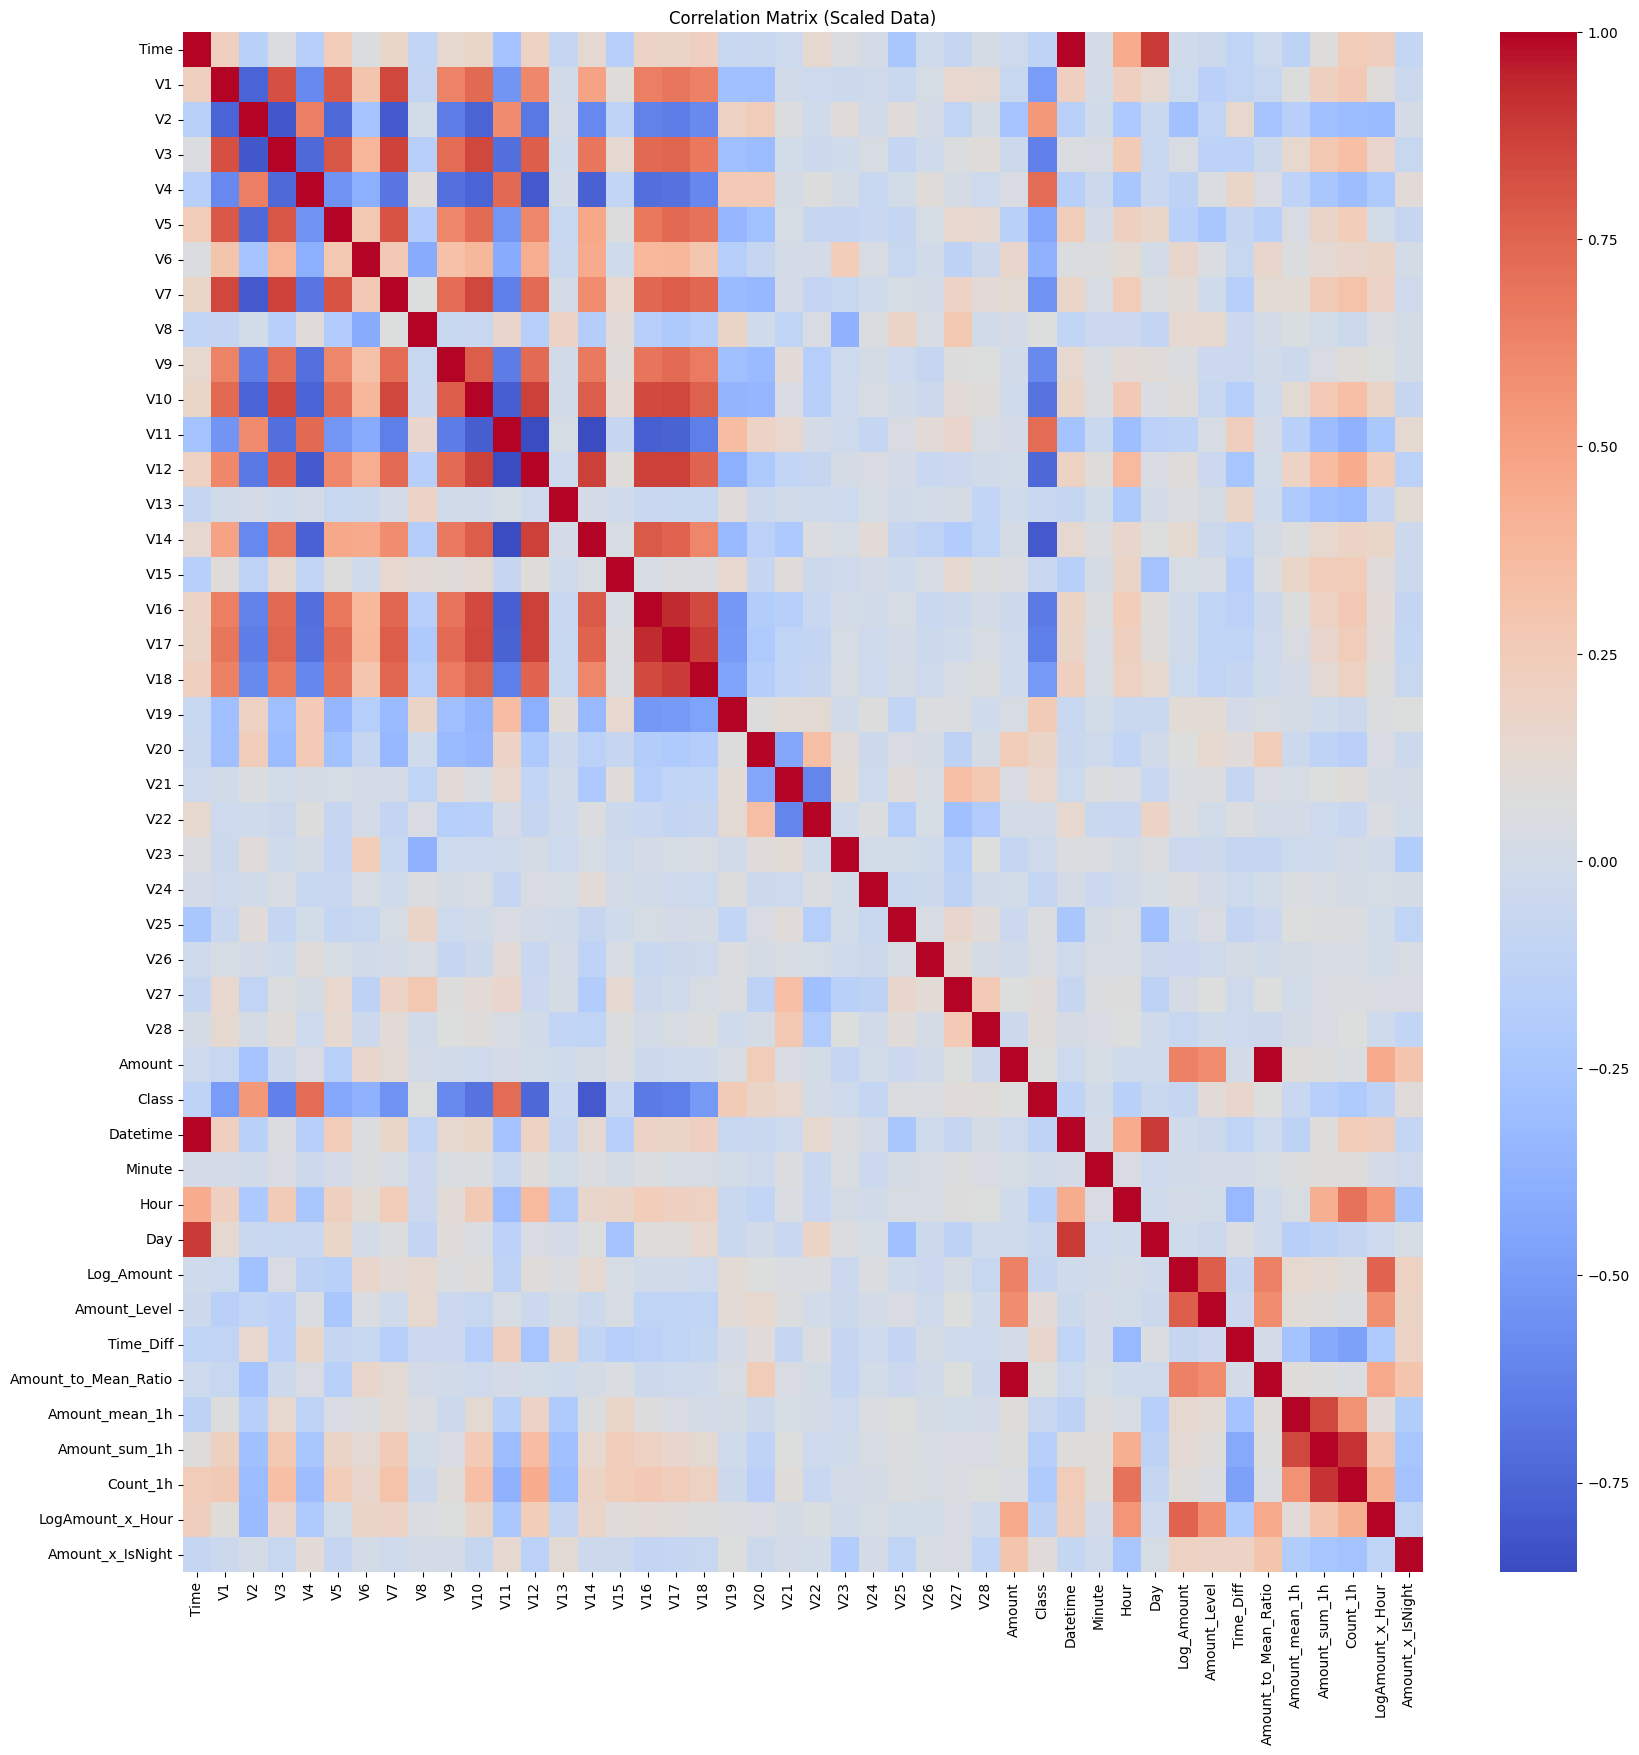

In [151]:

plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(),cmap='coolwarm')
plt.title("Correlation Matrix (Scaled Data)")
plt.show()
X = X_scal

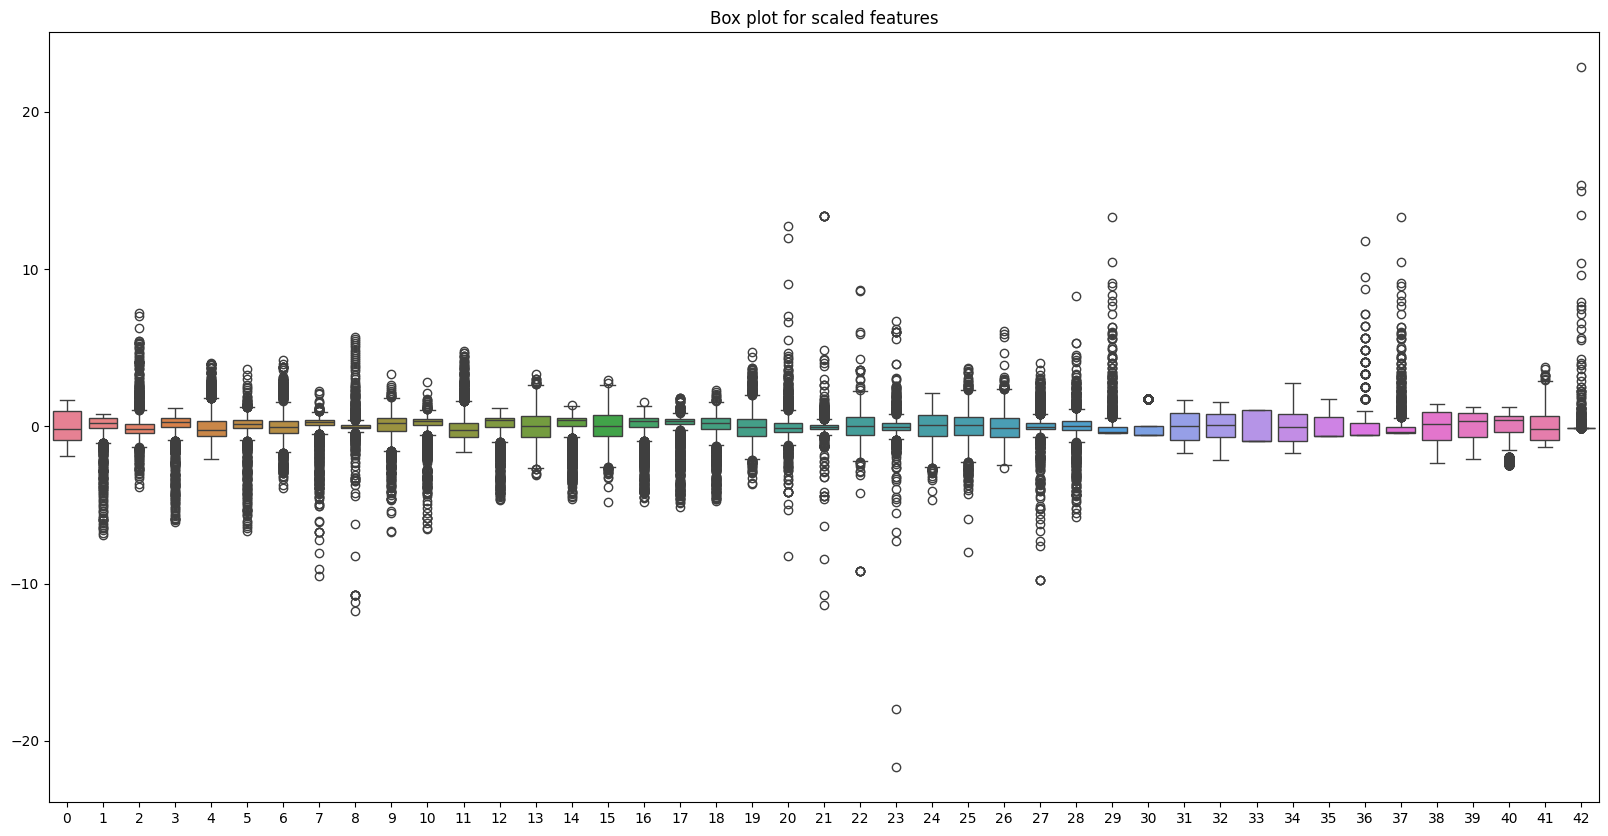

In [152]:
plt.figure(figsize=(20,10))
sns.boxplot(X_scal)
plt.title('Box plot for scaled features')
plt.show()

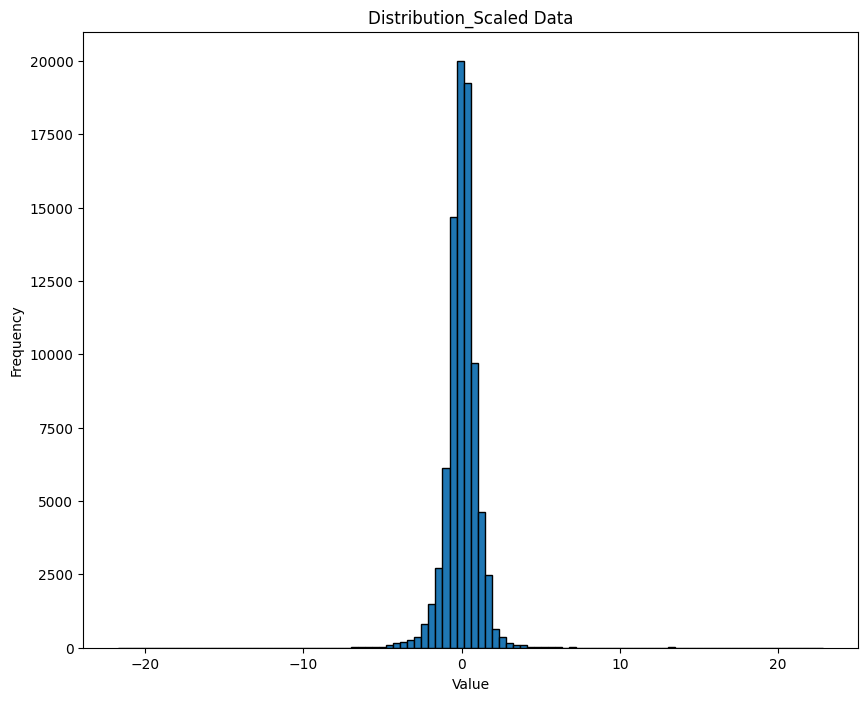

In [153]:
plt.figure(figsize=(10,8))
plt.hist(X_scal.flatten(),bins=100,edgecolor='black')
plt.title('Distribution_Scaled Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# **PCA coding**

In [154]:
# I calculated the variance and applied PCA manually to see how many components explain 90% and 95% of the variance.

# هون حسبت التباين بين المتغيرات وطبقت PCA يدوي، عشان أحدد كم مكون بيكفوا يشرحوا 90% و95% من التباين.



In [155]:
covariance=np.cov(X_scal.T)
eig_value,eig_vector=np.linalg.eig(covariance)
explained_variance_ratio=eig_value/eig_value.sum()
cumulative_explained_variance=np.cumsum(explained_variance_ratio)
n_component_90=np.argmax(cumulative_explained_variance>=0.90)+1
n_component_95=np.argmax(cumulative_explained_variance>=0.95)+1
print("Component ≥90% v:", n_component_90)
print("Component ≥95% v:", n_component_95)

Component ≥90% v: 20
Component ≥95% v: 25


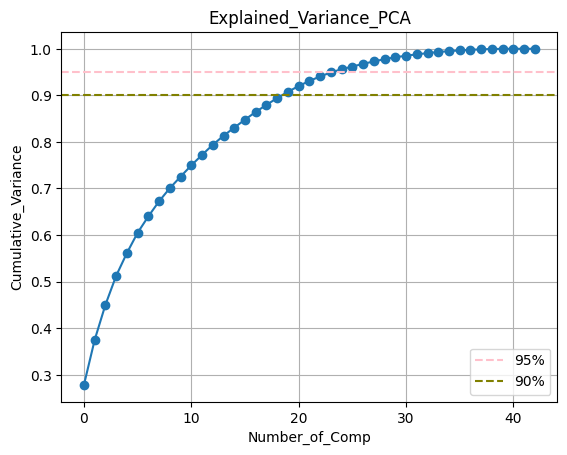

In [156]:
plt.plot(cumulative_explained_variance,marker='o')
plt.axhline(0.95,c='pink',ls='--',label='95%')
plt.axhline(0.90,c='olive',ls='--',label='90%')
plt.xlabel('Number_of_Comp')
plt.ylabel('Cumulative_Variance')
plt.title('Explained_Variance_PCA')
plt.legend()
plt.grid()
plt.show()

In [157]:
best_component=n_component_90
print(best_component)
pca_90=PCA(n_components=best_component,random_state=42)
X_pca_90=pca_90.fit_transform(X_scal)
print('Dimensions reduced from', X_scal.shape[1], "to", X_pca_90.shape[1], "features")

20
Dimensions reduced from 43 to 20 features


In [158]:
best_component=n_component_95
pca_95=PCA(n_components=best_component,random_state=42)
X_pca_95=pca_95.fit_transform(X_scal)
print('Dimensions reduced from', X_scal.shape[1], "to", X_pca_95.shape[1], "features")

Dimensions reduced from 43 to 25 features


In [159]:
# I used 2D PCA to check if there's a clear separation between fraud and normal transactions after dimensionality reduction.

# هون استخدمت PCA ثنائي الأبعاد عشان أشوف إذا في تمييز واضح بين العمليات الاحتيالية والعادية بعد التقليل من الأبعاد.



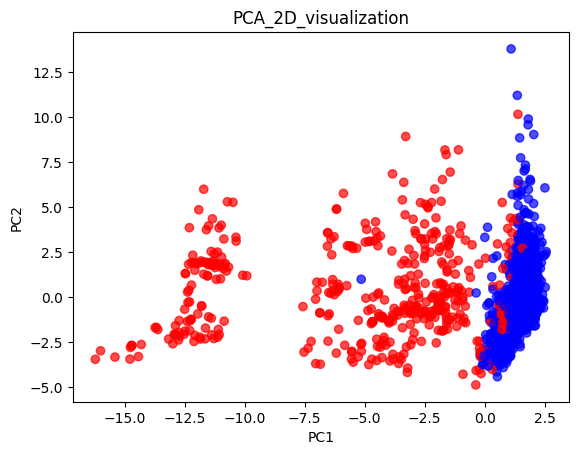

In [160]:
color={1:'red',0:'blue'}
colors=y.map(color)
pca_2d = PCA(n_components=2).fit_transform(X_scal)
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=colors, alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA_2D_visualization')
plt.show()

In [161]:
# I converted the PCA results into a DataFrame and added the Class column to visualize the difference between fraud and normal

# أنا حولت نتائج الـ PCA لداتا فريم، وضفت عمود الكلاس، عشان أقدر أشوف الفرق بين الاحتيال والعادي بالرسم


In [162]:
df_pca=pd.DataFrame(pca_2d,columns=[f'PC{i+1}'for i in range(pca_2d.shape[1])])
df_pca['Class']=y.values

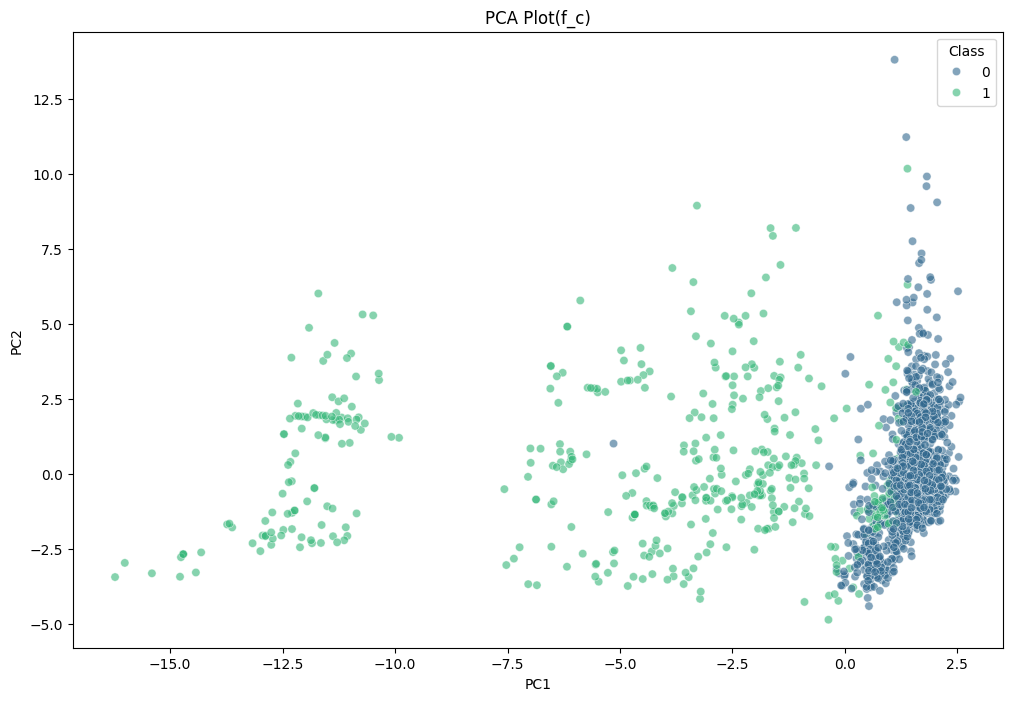

In [163]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1',y='PC2',hue='Class',data=df_pca,palette='viridis',alpha=0.6)
plt.title('PCA Plot(f_c)')
plt.show()

In [164]:
print(pca_2d.shape)
print(y.shape)

(1968, 2)
(1968,)


# **TSNE coding befor clusturing**

In [165]:
# Here I applied t-SNE on the PCA results to visualize the separation between classes more clearly, and stored the output in a DataFrame with the class labels

# هون طبّقت t-SNE على نتائج الـ PCA عشان أقدر أوضح الفصل بين الكلاسات بشكل أوضح، وبعدين خزّنت النتائج بداتا فريم مع الكلاس


In [166]:
tsne=TSNE(n_components=2,random_state=42,perplexity=30)
X_tsne=tsne.fit_transform(pca_2d)
df_tsne=pd.DataFrame(X_tsne,columns=['TSNE1','TSNE2'])
df_tsne['Class']=y.values

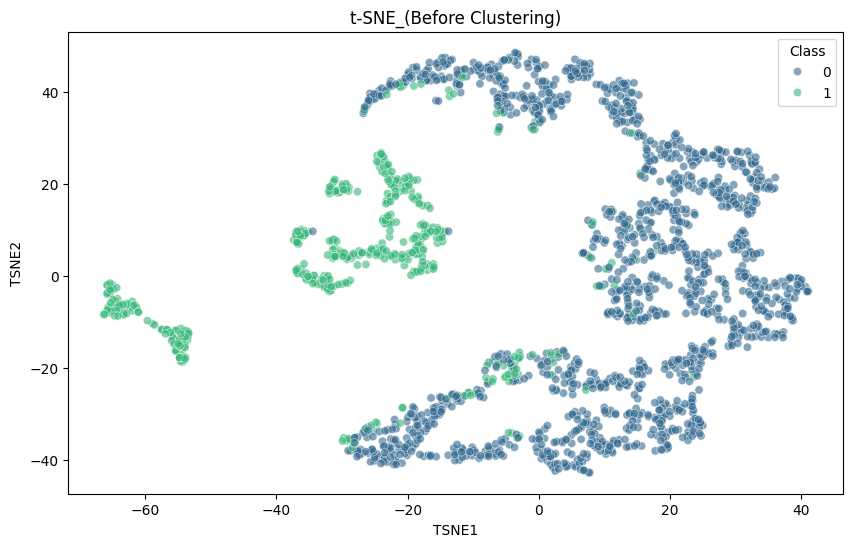

In [167]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1',y='TSNE2',hue='Class',data=df_tsne,palette='viridis',alpha=0.6)
plt.title('t-SNE_(Before Clustering)')
plt.show()

In [168]:
# Here I applied t-SNE on the PCA-reduced data that retains 95% of the variance, to visualize how the points are distributed after dimensionality reduction.

# هون استخدمت t-SNE على البيانات اللي حافظت على 95% من التباين بعد الـ PCA، عشان أشوف كيف بترتب النقاط بصريًا بعد تقليل الأبعاد.

In [169]:
tsne=TSNE(n_components=2,random_state=42,perplexity=30)
X_tsne=tsne.fit_transform(X_pca_95)
df_tsne=pd.DataFrame(X_tsne,columns=['TSNE1','TSNE2'])
df_tsne['Class']=y.values

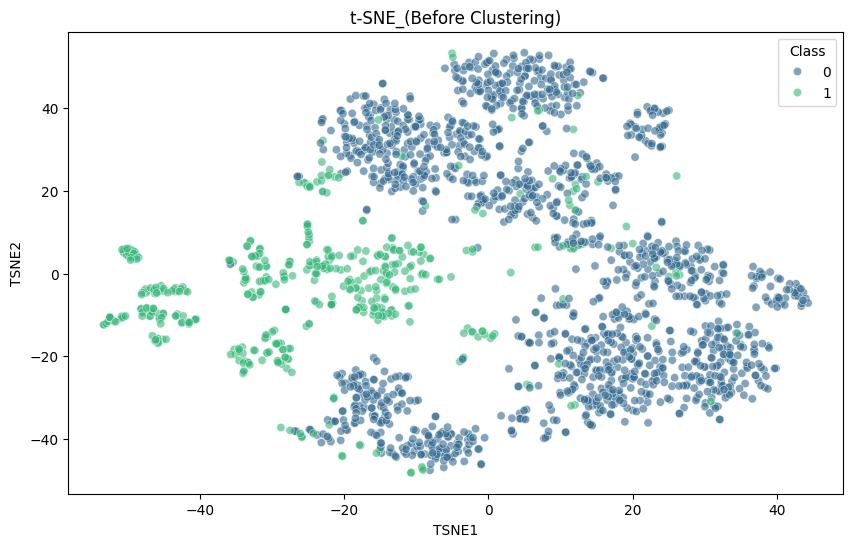

In [170]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1',y='TSNE2',hue='Class',data=df_tsne,palette='viridis',alpha=0.6)
plt.title('t-SNE_(Before Clustering)')
plt.show()

# **Clusturing**

# **Kmeans coding**

In [171]:
# Here I was trying to choose the optimal number of clusters by testing different k values and checking the inertia for each, to apply the elbow method.
# Inertia measures how close the points are to their cluster center. Lower is better, but we don’t want to overfit by choosing too many clusters.

# هون كنت بحاول أختار عدد الكلاسترز الأنسب عن طريق اختبار قيم مختلفة لـ k، وبشوف الإينيرشيا لكل وحدة عشان أستخدم طريقة الكوع.

# الإينيرشيا بتقيس قديش النقاط قريبة من مركز الكلاستر، فكل ما كانت أقل كل ما كانت التجمعات أفضل، بس لازم ننتبه ما نختار عدد كبير كتير



In [172]:
k_range=range(2,20)
inertia=[]
for k in k_range:
  k_means=KMeans(n_clusters=k,n_init=10, random_state=42, algorithm="elkan")
  k_means.fit(pca_2d)
  inertia.append(k_means.inertia_)

In [173]:
# 4 or 5 because that’s the elbow point where improvement starts to level off.
# ٤ أو ٥ لأنها نقطة الكوع التي يبدأ بعدها التحسّن في النموذج يصبح بسيطًا جدًا.


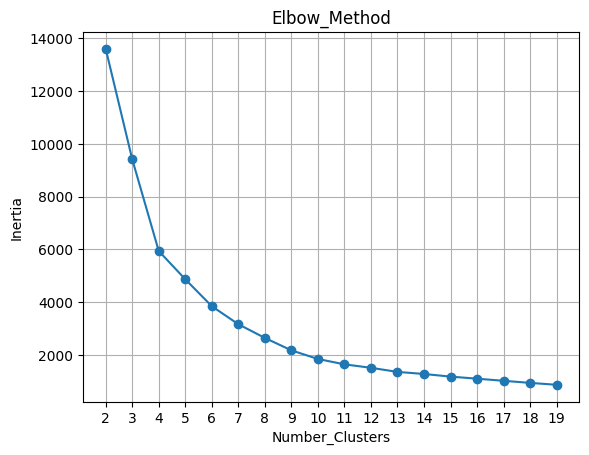

In [174]:
plt.plot(k_range,inertia,marker='o',linestyle='-')
plt.xlabel('Number_Clusters')
plt.ylabel('Inertia')
plt.title('Elbow_Method')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [175]:
# Here I applied the Elbow Method on the scaled data without PCA, to help choose the optimal number of clusters by observing the inertia for each k value

# Using the Elbow Method, I observed that the elbow point is around k = 8, because after that, the decrease in inertia becomes minimal
#  so I selected 8 as the optimal number of clusters.


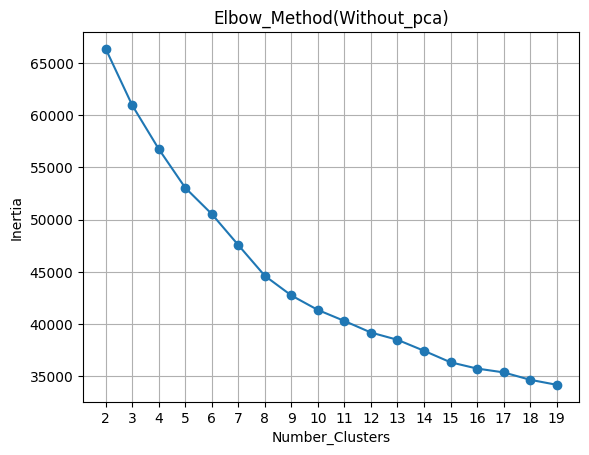

In [176]:
k_range=range(2,20)
inertia=[]
for k in k_range:
  k_means=KMeans(n_clusters=k,n_init=10, random_state=42, algorithm="elkan")
  k_means.fit(X_scal)
  inertia.append(k_means.inertia_)
plt.plot(k_range,inertia,marker='o',linestyle='-')
plt.xlabel('Number_Clusters')
plt.ylabel('Inertia')
plt.title('Elbow_Method(Without_pca)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [177]:
# After applying PCA for dimensionality reduction, I used the Silhouette Score to evaluate KMeans performance. The best number of clusters was k =2
# since it gave the highest silhouette score, indicating well-separated clusters.


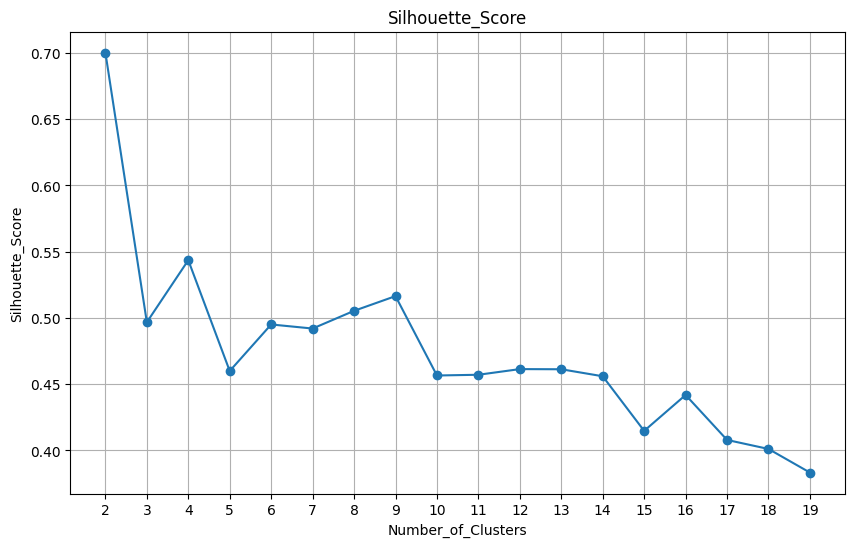

In [178]:
scores=[]
k_values=range(2,20)
for k in k_values:
  kmeans=KMeans(n_clusters=k,n_init=5,random_state=42,algorithm="elkan").fit(pca_2d)
  score=silhouette_score(pca_2d,kmeans.labels_)
  scores.append(score)
best_k=k_values[scores.index(max(scores))]
final_mod=KMeans(n_clusters=best_k,n_init=10,random_state=42,algorithm="elkan").fit(pca_2d)
plt.figure(figsize=(10,6))
plt.plot(k_values,scores,marker='o',linestyle='-')
plt.xlabel('Number_of_Clusters')
plt.ylabel('Silhouette_Score')
plt.title('Silhouette_Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [179]:
# The best number of clusters is k = 2 because it gave the highest Silhouette Score without PCA.


In [180]:
print(scores)
print(best_k)

[np.float64(0.7002798961560255), np.float64(0.49676019419442946), np.float64(0.5435999506926574), np.float64(0.4599637113631914), np.float64(0.4950810332646351), np.float64(0.4920085751881961), np.float64(0.5053705496569632), np.float64(0.5164793995785597), np.float64(0.4565655507038747), np.float64(0.4571240186633525), np.float64(0.46139451859430886), np.float64(0.4612743920912529), np.float64(0.45599026738306475), np.float64(0.41477109986385097), np.float64(0.4418584328459149), np.float64(0.4079249568921442), np.float64(0.40112071768631513), np.float64(0.3832948209142222)]
2


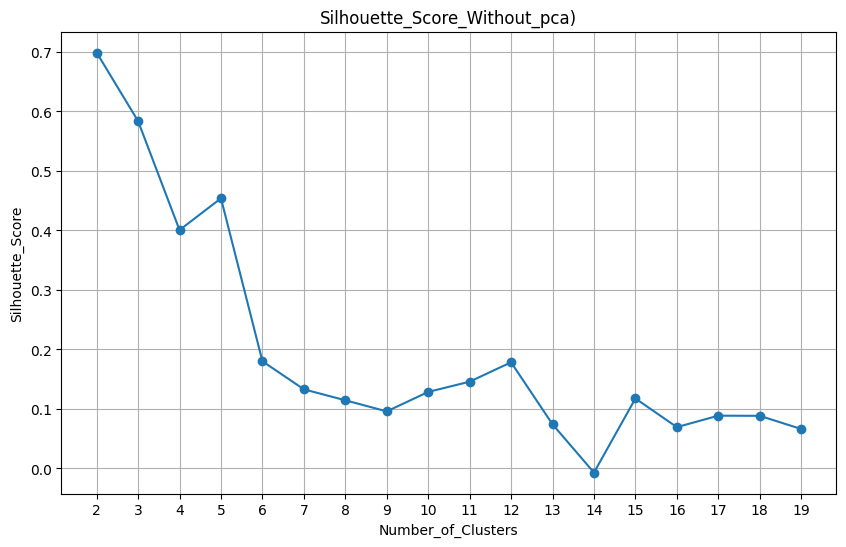

[np.float64(0.6989015706908003), np.float64(0.5836602434198918), np.float64(0.40052103368153485), np.float64(0.4538855409741853), np.float64(0.17994750566748097), np.float64(0.13273111174432928), np.float64(0.1142993829610941), np.float64(0.09566634512277454), np.float64(0.12834006206787096), np.float64(0.14562141033168957), np.float64(0.17814980302384148), np.float64(0.07390057010603264), np.float64(-0.007248272005734187), np.float64(0.11735398705852312), np.float64(0.06917753741877133), np.float64(0.08843140652212639), np.float64(0.0881722181207114), np.float64(0.06604922755901925)]
2


In [181]:
scores_1=[]
k_values=range(2,20)
for k in k_values:
  kmeans=KMeans(n_clusters=k,n_init=5,random_state=42,algorithm="elkan").fit(X_scal)
  score_1=silhouette_score(pca_2d,kmeans.labels_)
  scores_1.append(score_1)
best_k_1=k_values[scores_1.index(max(scores_1))]
final_mod=KMeans(n_clusters=best_k_1,n_init=10,random_state=42,algorithm="elkan").fit(X_scal)
plt.figure(figsize=(10,6))
plt.plot(k_values,scores_1,marker='o',linestyle='-')
plt.xlabel('Number_of_Clusters')
plt.ylabel('Silhouette_Score')
plt.title('Silhouette_Score_Without_pca)')
plt.xticks(k_values)
plt.grid(True)
plt.show()
print(scores_1)
print(best_k_1)

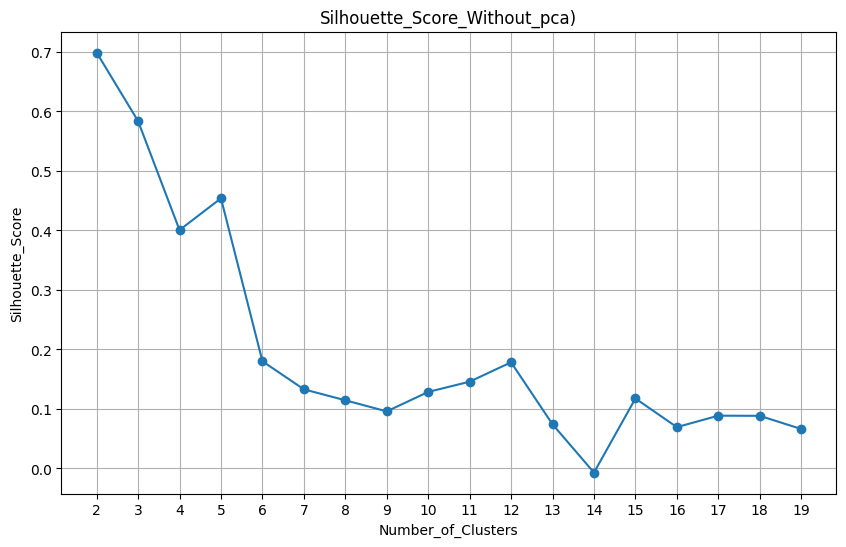

[np.float64(0.6989015706908003), np.float64(0.5836602434198918), np.float64(0.40052103368153485), np.float64(0.4538855409741853), np.float64(0.17994750566748097), np.float64(0.13273111174432928), np.float64(0.1142993829610941), np.float64(0.09566634512277454), np.float64(0.12834006206787096), np.float64(0.14562141033168957), np.float64(0.17814980302384148), np.float64(0.07390057010603264), np.float64(-0.007248272005734187), np.float64(0.11735398705852312), np.float64(0.06917753741877133), np.float64(0.08843140652212639), np.float64(0.0881722181207114), np.float64(0.06604922755901925)]
2


In [182]:
scores_1=[]
k_values=range(2,20)
for k in k_values:
  kmeans=KMeans(n_clusters=k,n_init=5,random_state=42,algorithm="elkan").fit(X_scal)
  score_1=silhouette_score(pca_2d,kmeans.labels_)
  scores_1.append(score_1)
best_k_1=k_values[scores_1.index(max(scores_1))]
final_mod=KMeans(n_clusters=best_k_1,n_init=10,random_state=42,algorithm="elkan").fit(X_scal)
plt.figure(figsize=(10,6))
plt.plot(k_values,scores_1,marker='o',linestyle='-')
plt.xlabel('Number_of_Clusters')
plt.ylabel('Silhouette_Score')
plt.title('Silhouette_Score_Without_pca)')
plt.xticks(k_values)
plt.grid(True)
plt.show()
print(scores_1)
print(best_k_1)

In [183]:
# I used silhouette plots for different k values after dimensionality reduction to see which number of clusters gives clearer and more separated groupings
# جربت أرسم الـ Silhouette plot لعدة قيم مختلفة من عدد الكلاسترز، بعد تقليل الأبعاد، حتى أشوف لأي قيمة k التجمعات بتكون أوضح وأكثر تمايز


In [184]:
# k = 2 is best: highest silhouette, least overlap.

# k = 2 هو الأفضل: أعلى سيلويت وأقل تداخل



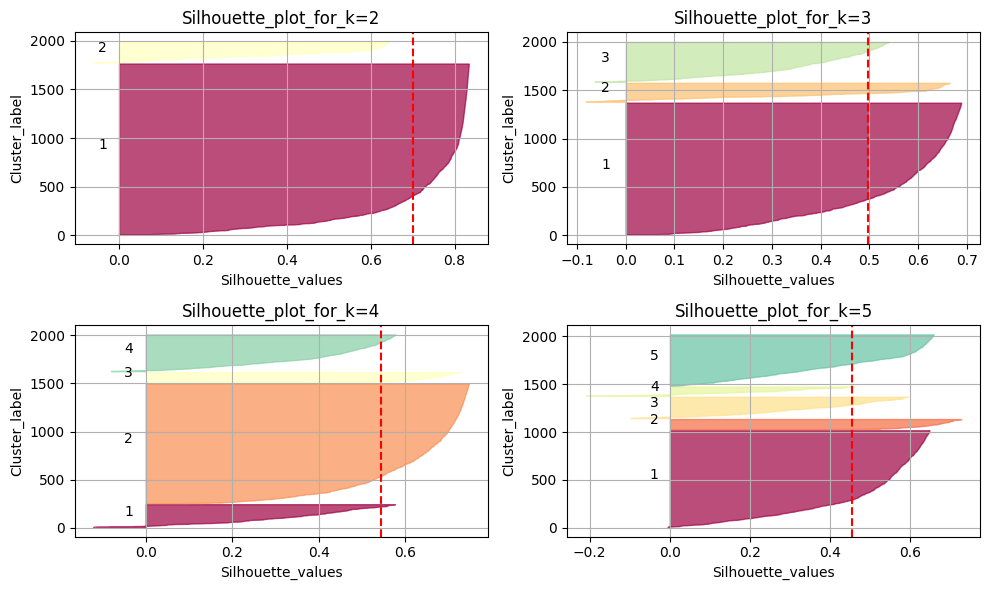

In [185]:
k_v=[2,3,4,5]
plt.figure(figsize=(10,6))
for k in k_v:
  k_means=KMeans(n_clusters=k,n_init=10,random_state=42,algorithm="elkan").fit(pca_2d)
  silhouette__vals=silhouette_samples(pca_2d,k_means.labels_)
  plt.subplot(2,2,k-1)
  y_lower=10
  for i in range(k):
    cluster_vals = np.sort(silhouette__vals[k_means.labels_ == i])
    plt.fill_betweenx(np.arange(y_lower,y_lower+len(cluster_vals)),0,cluster_vals,color=cm.Spectral(i/k),alpha=0.7)
    plt.text(-0.05,y_lower+len(cluster_vals)/2,str(i+1))
    y_lower+=len(cluster_vals)+10
  plt.axvline(np.mean(silhouette__vals),color="red",linestyle="--")
  plt.title(f"Silhouette_plot_for_k={k}")
  plt.xlabel("Silhouette_values")
  plt.ylabel("Cluster_label")
  plt.grid(True)
plt.tight_layout()
plt.show()

In [186]:
# I plotted silhouette diagrams for different k values without PCA, and noticed from the shape and separation that k = 2 looked better.

# رسمت مخططات السيلويت لأكثر من قيمة k بدون تقليل الأبعاد، ولاحظت من التوزيع والتباعد أن بعض القيم مثل k = 2كانت أفضل.




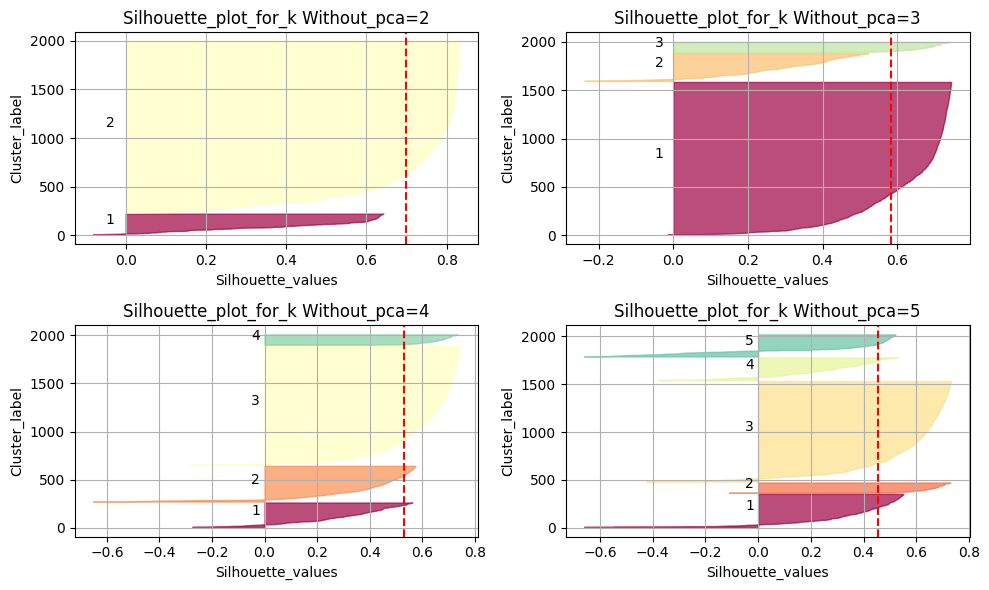

In [187]:
k_v=[2,3,4,5]
plt.figure(figsize=(10,6))
for k in k_v:
  k_means=KMeans(n_clusters=k,n_init=10,random_state=42,algorithm="elkan").fit(X_scal)
  silhouette__vals=silhouette_samples(pca_2d,k_means.labels_)
  plt.subplot(2,2,k-1)
  y_lower=10
  for i in range(k):
    cluster_vals = np.sort(silhouette__vals[k_means.labels_ == i])
    plt.fill_betweenx(np.arange(y_lower,y_lower+len(cluster_vals)),0,cluster_vals,color=cm.Spectral(i/k),alpha=0.7)
    plt.text(-0.05,y_lower+len(cluster_vals)/2,str(i+1))
    y_lower+=len(cluster_vals)+10
  plt.axvline(np.mean(silhouette__vals),color="red",linestyle="--")
  plt.title(f"Silhouette_plot_for_k Without_pca={k}")
  plt.xlabel("Silhouette_values")
  plt.ylabel("Cluster_label")
  plt.grid(True)
plt.tight_layout()
plt.show()

# **Kmeans**++

In [188]:
# طبّق خوارزمية KMeans باستخدام pca_2d
# ويحسب Inertia، وSilhouette Score، والزمن المستغرق لكل قيمة k من 2 إلى 19.
# أفضل عدد عناقيد هو 2، لأنه أعطى أعلى Silhouette Score وأقل زمن تنفيذ بعد تقليل الأبعاد.

# The best number of clusters is 2 because it gave the highest Silhouette Score and fastest execution time after dimensionality reduction.



In [189]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

inertia = []
silhouette_scores = []
cluster_range = range(2, 20)

print("KMeans Clustering Results:")
print("{:<10} {:<15} {:<18} {:<10}".format("Clusters", "Inertia", "Silhouette Score", "Time(s)"))
print("-" * 60)

for k in cluster_range:
    start_time = time.time()

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, algorithm="elkan", init="k-means++")
    kmeans.fit(pca_2d)

    inertia_val = kmeans.inertia_
    silh_score = silhouette_score(pca_2d, kmeans.labels_)
    time_taken = time.time() - start_time

    inertia.append(inertia_val)
    silhouette_scores.append(silh_score)

    print("{:<10} {:<15.2f} {:<18.3f} {:<10.3f}".format(k, inertia_val, silh_score, time_taken))


KMeans Clustering Results:
Clusters   Inertia         Silhouette Score   Time(s)   
------------------------------------------------------------
2          13591.57        0.700              0.097     
3          9413.88         0.497              0.111     
4          5942.20         0.544              0.127     
5          4873.64         0.454              0.124     
6          3854.12         0.495              0.212     
7          3172.78         0.501              0.295     
8          2654.39         0.505              0.260     
9          2184.86         0.516              0.275     
10         1857.81         0.457              0.145     
11         1655.01         0.460              0.144     
12         1524.41         0.461              0.147     
13         1369.09         0.461              0.162     
14         1290.29         0.456              0.170     
15         1190.93         0.415              0.184     
16         1112.56         0.442              0.180     


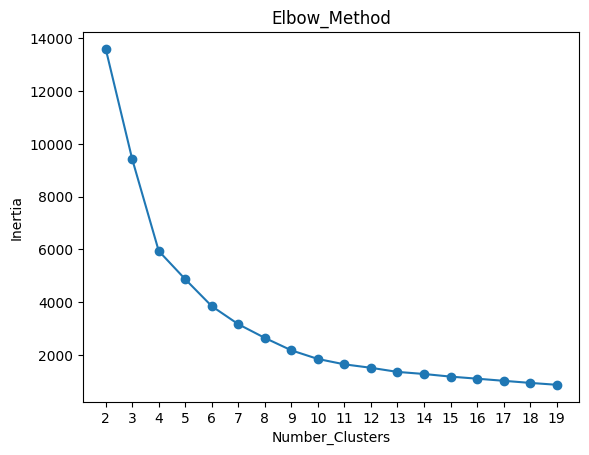

In [190]:
plt.plot(cluster_range,inertia,marker='o',linestyle='-')
plt.xlabel('Number_Clusters')
plt.ylabel('Inertia')
plt.title('Elbow_Method')
plt.xticks(cluster_range)
plt.show()

Minibatchkmeans

In [191]:
# هنا طبّقت Elbow وSilhouette Score على البيانات الأصلية بدون استخدام PCA، للمقارنة بين الأداء قبل وبعد تقليل الأبعاد.

# Here I applied the Elbow Method and Silhouette Score on the original scaled data (without PCA), to compare the performance before and after dimensionality reduction.

# k = 2 هو الأفضل لأنّه أعطى أعلى Silhouette Score = 0.480، وهي أعلى قيمة في الجدول.



KMeans Clustering Results:
Clusters   Inertia         Silhouette Score   Time(s)   
------------------------------------------------------------
2          66357.90        0.458              0.143     
3          60947.31        0.274              0.146     
4          56759.30        0.164              0.180     
5          53042.09        0.159              0.177     
6          50533.34        0.202              0.193     
7          47559.98        0.093              0.199     
8          44614.33        0.101              0.195     
9          42733.96        0.111              0.265     
10         41345.30        0.115              0.357     
11         40290.09        0.123              0.405     
12         39183.05        0.121              0.389     
13         38487.44        0.121              0.377     
14         37437.39        0.097              0.444     
15         36334.84        0.131              0.395     
16         35733.22        0.114              0.441     


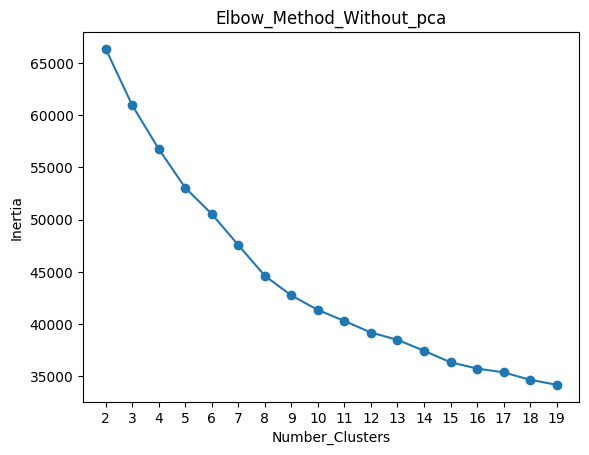

In [192]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

inertia = []
silhouette_scores = []
cluster_range = range(2, 20)

print("KMeans Clustering Results:")
print("{:<10} {:<15} {:<18} {:<10}".format("Clusters", "Inertia", "Silhouette Score", "Time(s)"))
print("-" * 60)

for k in cluster_range:
    start_time = time.time()

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, algorithm="elkan", init="k-means++")
    kmeans.fit(X_scal)

    inertia_val = kmeans.inertia_
    silh_score = silhouette_score(X_scal, kmeans.labels_)
    time_taken = time.time() - start_time

    inertia.append(inertia_val)
    silhouette_scores.append(silh_score)

    print("{:<10} {:<15.2f} {:<18.3f} {:<10.3f}".format(k, inertia_val, silh_score, time_taken))
plt.plot(cluster_range,inertia,marker='o',linestyle='-')
plt.xlabel('Number_Clusters')
plt.ylabel('Inertia')
plt.title('Elbow_Method_Without_pca')
plt.xticks(cluster_range)
plt.show()


In [193]:
# Using MiniBatchKMeans on PCA-reduced data, the optimal number of clusters is k = 2, as it yielded the highest Silhouette Score of 0.716



In [194]:
inertia = []
silhouette_scores = []
cluster_range = range(2, 20)

print("MiniBatchKMeans Clustering Results:\n")
print("{:<10} {:<15} {:<15} {:<10}".format("Clusters", "Inertia", "Silhouette", "Time(s)"))
print("-" * 50)

for k in cluster_range:
    start_time = time.time()

    m_b= MiniBatchKMeans(n_clusters=k, batch_size=100, random_state=42)
    m_b.fit(pca_2d)

    inertia_val = m_b.inertia_
    silh_score = silhouette_score(pca_2d, m_b.labels_)
    time_taken = round(time.time() - start_time, 3)

    inertia.append(inertia_val)
    silhouette_scores.append(silh_score)

    print("{:<10} {:<15.2f} {:<15.3f} {:<10.3f}".format(k, inertia_val, silh_score, time_taken))


MiniBatchKMeans Clustering Results:

Clusters   Inertia         Silhouette      Time(s)   
--------------------------------------------------
2          13614.18        0.702           0.069     
3          10047.59        0.504           0.066     
4          6093.21         0.549           0.074     
5          4959.44         0.505           0.070     
6          4252.19         0.507           0.069     
7          3820.32         0.366           0.070     
8          2842.11         0.465           0.069     
9          2550.41         0.435           0.069     
10         2394.01         0.430           0.064     
11         1941.73         0.445           0.061     
12         1825.96         0.442           0.062     
13         1523.90         0.452           0.062     
14         1448.44         0.444           0.065     
15         1376.51         0.411           0.065     
16         1279.46         0.381           0.089     
17         1568.57         0.353           0.073

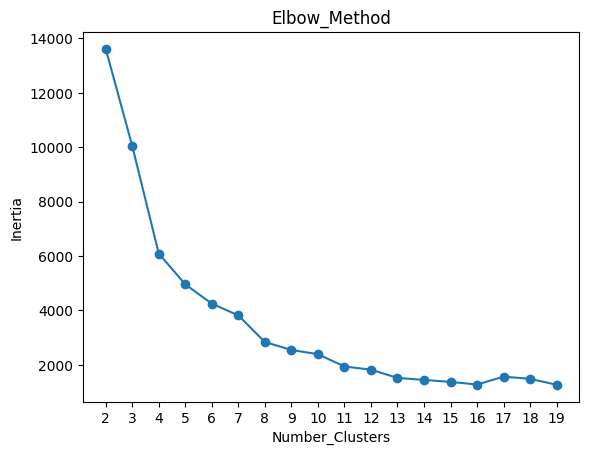

In [195]:
plt.plot(cluster_range,inertia,marker='o',linestyle='-')
plt.xlabel('Number_Clusters')
plt.ylabel('Inertia')
plt.title('Elbow_Method')
plt.xticks(cluster_range)
plt.show()

In [196]:
# استخدمت sys.getsizeof() عشان أقارن استهلاك الذاكرة بين KMeans و MiniBatchKMeans

In [197]:
print(f"Memory usage to MiniBatch ->{sys.getsizeof(m_b)} byts")
print(f"Memory usage to kmeans ->{sys.getsizeof(kmeans)} byts")


Memory usage to MiniBatch ->56 byts
Memory usage to kmeans ->56 byts


# **DBSCAN Clusturing**

In [198]:
# I used DBSCAN because it groups points based on density and can find outliers without choosing the number of clusters.

#after pca

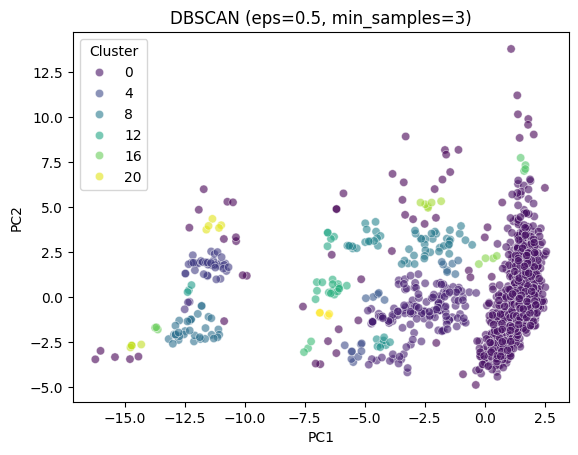

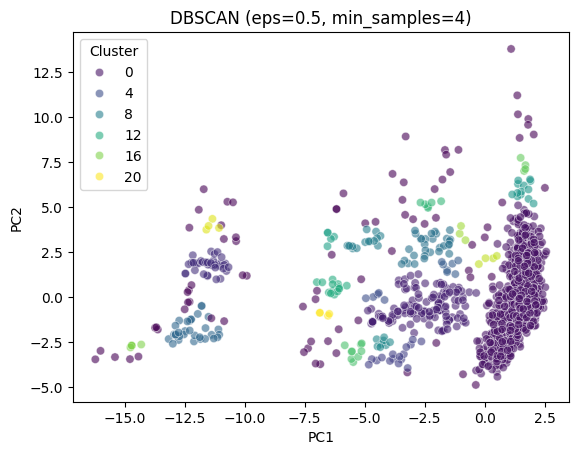

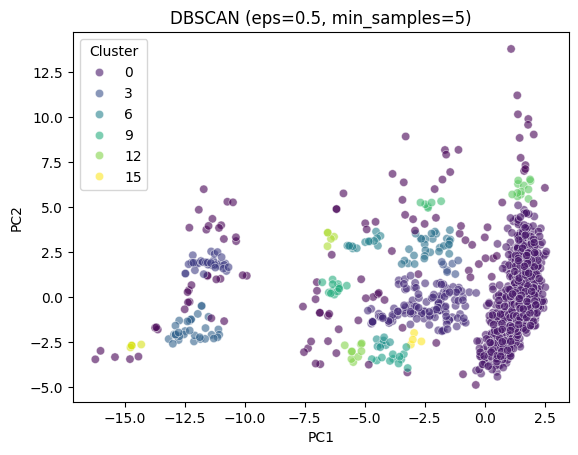

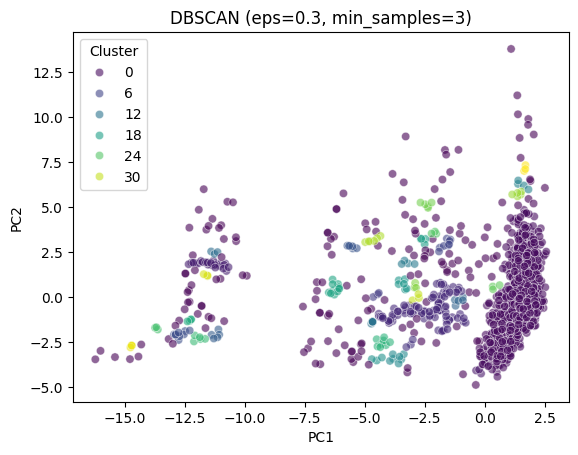

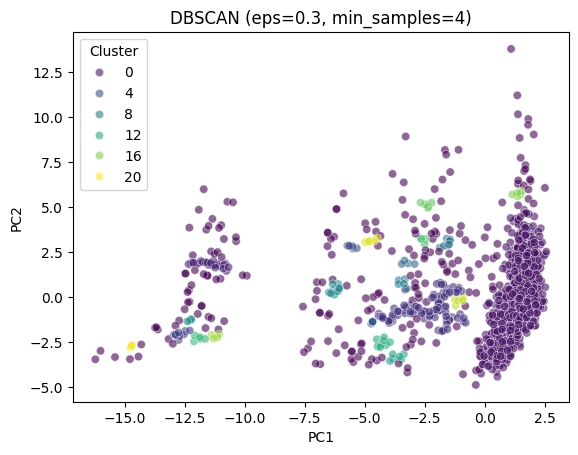

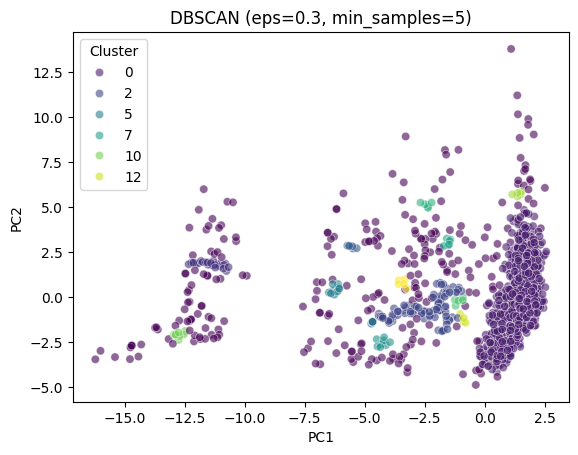

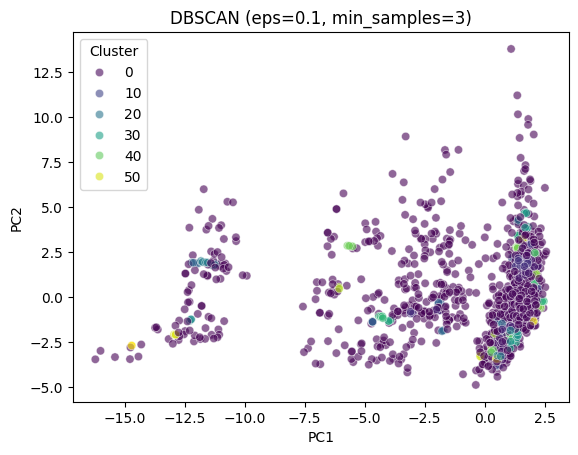

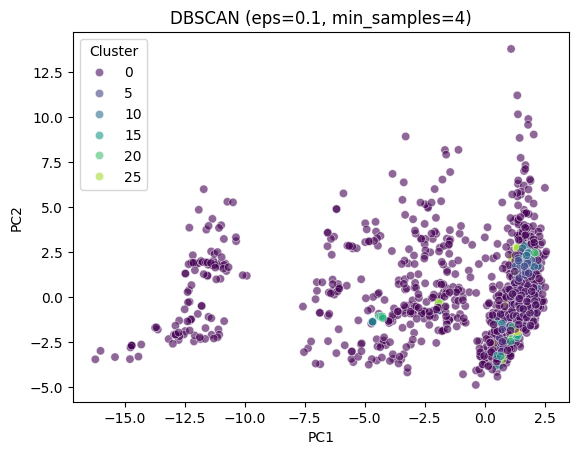

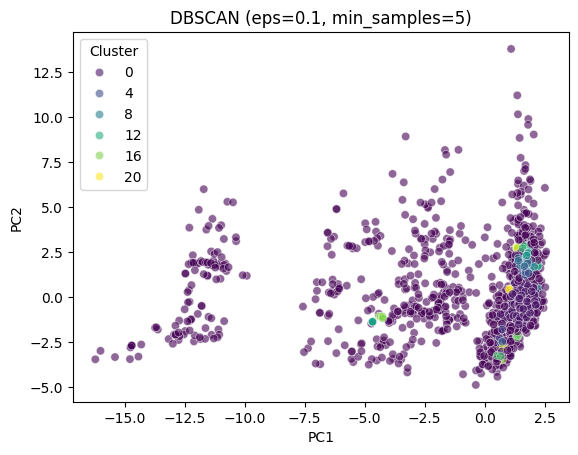

Time taken: 2.9015963077545166
DBSCAN eps=0.1, min_samples=5, Noise points: 784


In [199]:
start_time = time.time()
eps_v = [0.5,0.3,0.1]
min_samp_v = [3, 4, 5]
for eps in eps_v:
  for min_samples in min_samp_v:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(pca_2d)
    df = pd.DataFrame(pca_2d, columns=[f'PC{i+1}' for i in range(pca_2d.shape[1])])
    df['Cluster'] = dbscan_labels
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='viridis', alpha=0.6)
    plt.title('DBSCAN_Clustering')
    plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
end_time = time.time()
print(f"Time taken: {end_time - start_time}")
noise = list(dbscan_labels).count(-1)
print(f"DBSCAN eps={eps}, min_samples={min_samples}, Noise points: {noise}")

In [200]:
# I applied DBSCAN with different values of eps and min_samples on the scaled data to observe how density affects the number of clusters and noise points.

#befor pca

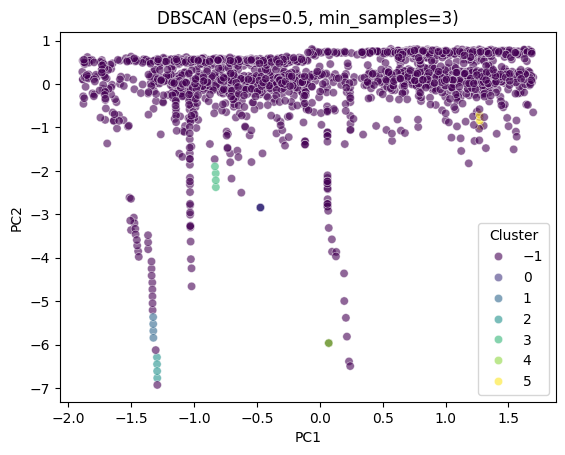

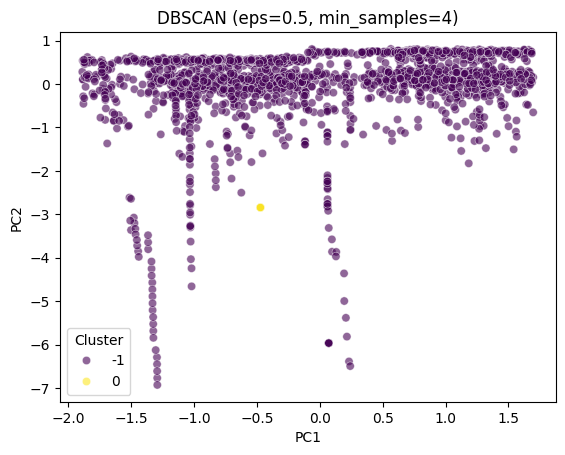

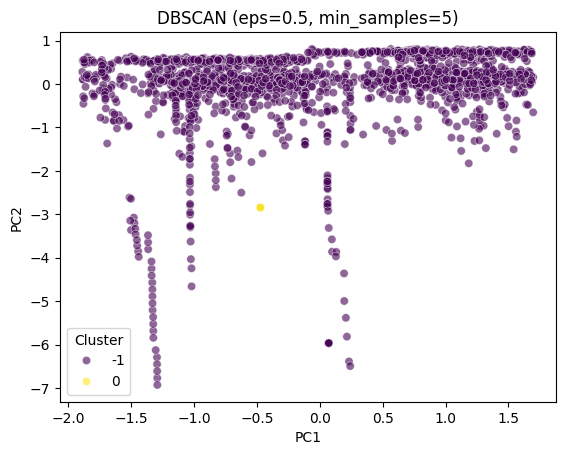

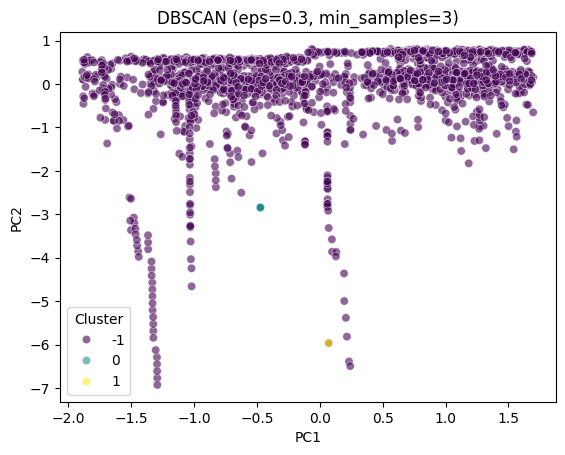

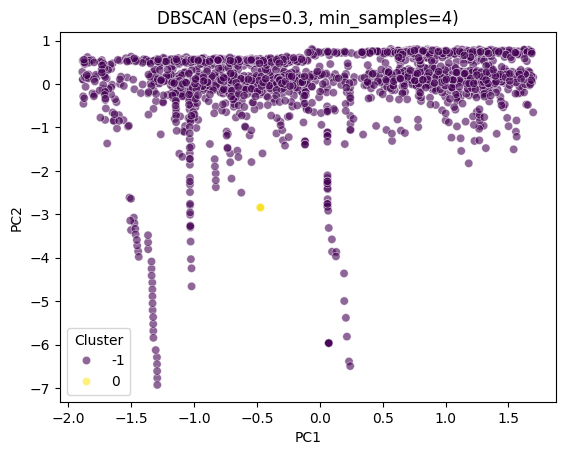

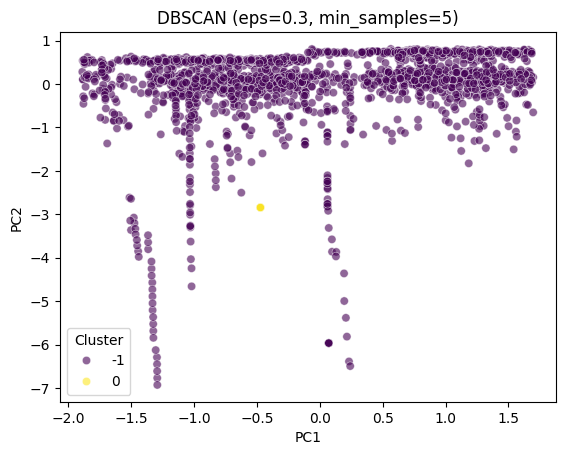

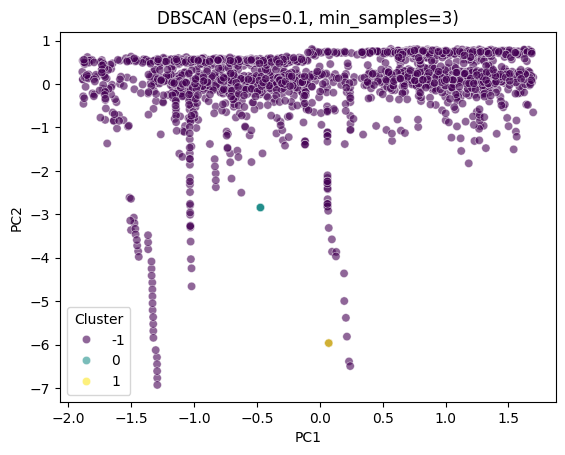

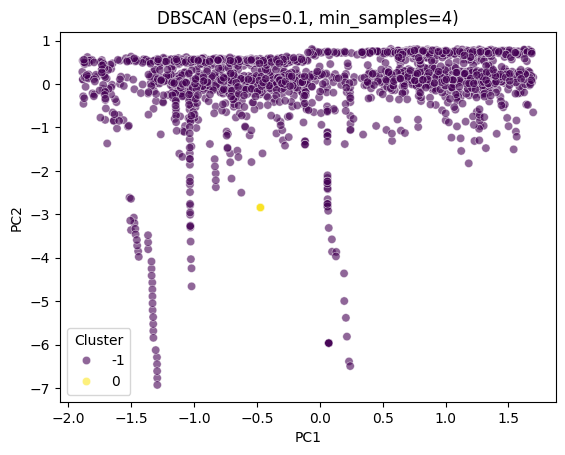

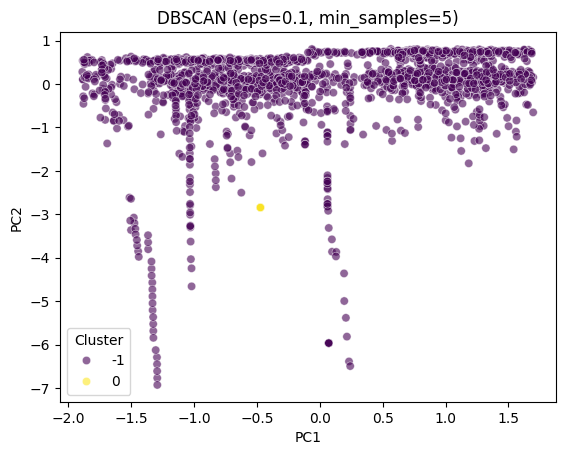

Time taken: 3.1201846599578857
DBSCAN eps=0.1, min_samples=5, Noise points: 1963


In [201]:
start_time = time.time()
eps_v = [0.5,0.3,0.1]
min_samp_v = [3, 4, 5]
for eps in eps_v:
  for min_samples in min_samp_v:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_scal)
    df = pd.DataFrame(X_scal, columns=[f'PC{i+1}' for i in range(X_scal.shape[1])])
    df['Cluster'] = dbscan_labels
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='viridis', alpha=0.6)
    plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
end_time = time.time()
print(f"Time taken: {end_time - start_time}")
noise = list(dbscan_labels).count(-1)
print(f"DBSCAN eps={eps}, min_samples={min_samples}, Noise points: {noise}")

In [202]:
# I used dbscan.components_ to check the core sample coordinates that formed the clusters based on density.


In [203]:
print(dbscan.components_)

[[ -0.47311352  -2.844171     4.0598898   -1.68685638   0.79988808
   -1.2620461    3.77527974  -3.92571747 -10.70612675   0.13749571
   -1.02034602   1.50814758  -0.8260925   -1.88221408  -1.93818828
   -0.24839854  -1.89772333  -1.00738608  -1.36353409  -0.14427907
   -4.17915935  13.35453217  -9.2184199    5.97654465  -1.05427003
    0.45803356  -0.24721002   1.63490396   2.7764846   -0.4219054
    1.73205081   1.52283444   0.76166652  -0.95526773  -1.30879132
   -0.60118751  -0.5583038   -0.4219054   -0.62338417   0.09665377
    0.70568607  -0.8981647   -0.13602307]
 [ -0.47311352  -2.844171     4.0598898   -1.68685638   0.79988808
   -1.2620461    3.77527974  -3.92571747 -10.70612675   0.13749571
   -1.02034602   1.50814758  -0.8260925   -1.88221408  -1.93818828
   -0.24839854  -1.89772333  -1.00738608  -1.36353409  -0.14427907
   -4.17915935  13.35453217  -9.2184199    5.97654465  -1.05427003
    0.45803356  -0.24721002   1.63490396   2.7764846   -0.4219054
    1.73205081   1.522

In [204]:
# I applied DBSCAN on both scaled data and PCA-reduced data with different values of eps and min_samples, and evaluated the number of clusters,
# noise points, and the Silhouette Score for each combination.



In [205]:


d_s = {'X_scaled': X_scal, 'X_pca': pca_2d}
eps_v = [0.3, 0.5, 0.7]
min_v = [3, 4, 5]

results = []

for data_name, X_data in d_s.items():
    for eps in eps_v:
        for min_samp in min_v:
            labels = DBSCAN(eps=eps, min_samples=min_samp).fit_predict(X_data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise = list(labels).count(-1)
            silh = round(silhouette_score(X_data, labels), 3) if n_clusters > 1 else None

            results.append({
                'Data': data_name,
                'eps': eps,
                'min_samples': min_samp,
                'Clusters': n_clusters,
                'Noise Points': noise,
                'Silhouette Score': silh
            })

df_results = pd.DataFrame(results)

print(" DBSCAN Clustering Results:\n")
print(df_results.to_string(index=False))


 DBSCAN Clustering Results:

    Data  eps  min_samples  Clusters  Noise Points  Silhouette Score
X_scaled  0.3            3         2          1960             0.628
X_scaled  0.3            4         1          1963               NaN
X_scaled  0.3            5         1          1963               NaN
X_scaled  0.5            3         6          1945             0.162
X_scaled  0.5            4         1          1963               NaN
X_scaled  0.5            5         1          1963               NaN
X_scaled  0.7            3         7          1942             0.164
X_scaled  0.7            4         4          1951             0.192
X_scaled  0.7            5         1          1963               NaN
   X_pca  0.3            3        34           179            -0.080
   X_pca  0.3            4        21           225             0.205
   X_pca  0.3            5        14           267             0.129
   X_pca  0.5            3        22            60             0.232
   X_

# **TSNE after clusturing**

In [206]:
# After clustering the PCA-transformed data using KMeans, I applied t-SNE just for visualization purposes, to better see how well the clusters are separated in 2D space.


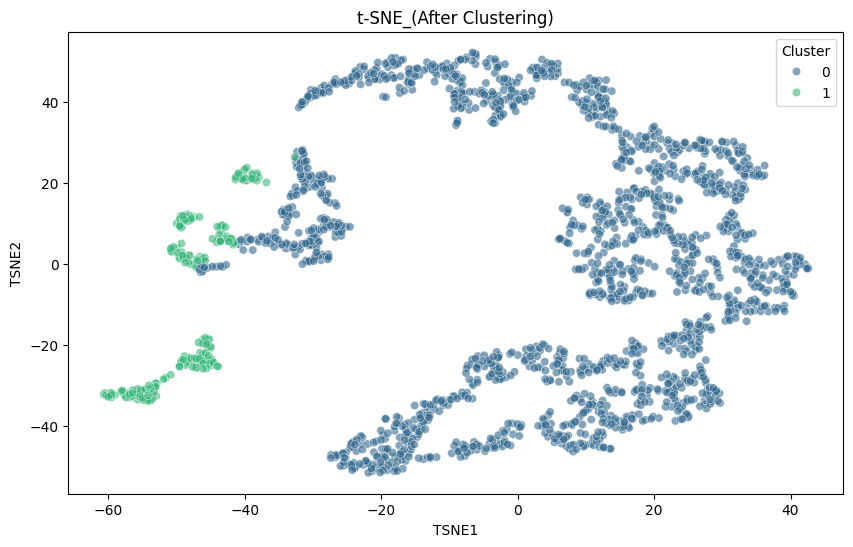

In [207]:
final_mod=KMeans(n_clusters=best_k,n_init=5,random_state=42,algorithm="elkan").fit(pca_2d)
labels=final_mod.labels_
X_tsne=TSNE(n_components=2,random_state=42,perplexity=30,early_exaggeration=20,learning_rate=200).fit_transform(pca_2d)
tsne_df=pd.DataFrame(X_tsne,columns=['TSNE1','TSNE2'])
tsne_df['Cluster']=final_mod.labels_
plt.figure(figsize=(10,6))
sns.scatterplot(x='TSNE1',y='TSNE2',hue='Cluster',data=tsne_df,palette='viridis',alpha=0.6)
plt.title('t-SNE_(After Clustering)')
plt.show()

In [208]:
# Just used KMeans on scaled data and visualized it with t-SNE to check how clusters look.


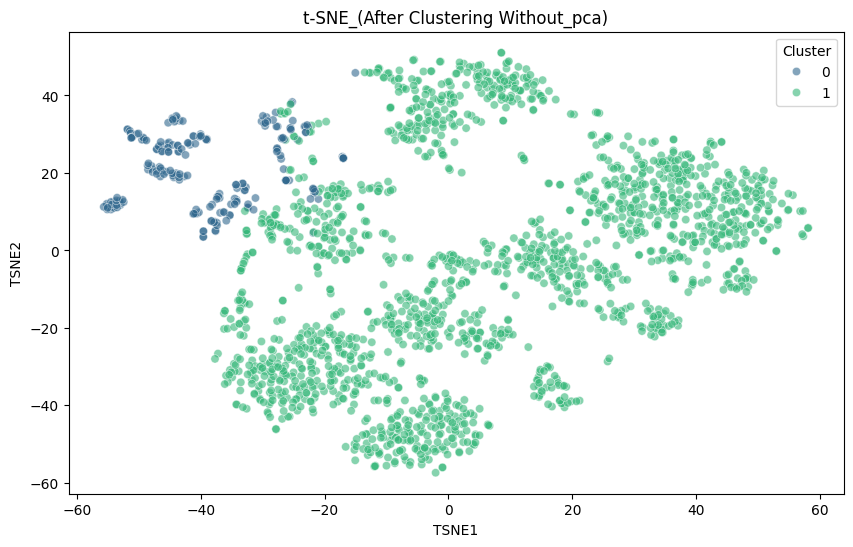

In [209]:
final_mod=KMeans(n_clusters=best_k,n_init=5,random_state=42,algorithm="elkan").fit(X_scal)
labels=final_mod.labels_
X_tsne=TSNE(n_components=2,random_state=42,perplexity=30,early_exaggeration=20,learning_rate=200).fit_transform(X_scal)
tsne_df=pd.DataFrame(X_tsne,columns=['TSNE1','TSNE2'])
tsne_df['Cluster']=final_mod.labels_
plt.figure(figsize=(10,6))
sns.scatterplot(x='TSNE1',y='TSNE2',hue='Cluster',data=tsne_df,palette='viridis',alpha=0.6)
plt.title('t-SNE_(After Clustering Without_pca)')
plt.show()

PCA + Train/Test Split


In [210]:
# We split the data into train and test sets using stratified sampling. Then we applied PCA to reduce the dimensionality of the training data, and used the same PCA transformation on the test set.

# قسمنا البيانات إلى تدريب واختبار بنسبة 80/20 مع الحفاظ على توزيع الفئات، وبعدين طبقنا PCA على بيانات التدريب لتقليل الأبعاد، وبعدها استخدمنا نفس التحويل على بيانات الاختبار.


In [211]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scal, y, test_size=0.2, random_state=42, stratify=y)
pca = PCA(n_components=2,random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [212]:
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_scal, y, test_size=0.2, random_state=42, stratify=y)
X_train_pca_1 = pca.fit_transform(X_train_1)
X_test_pca_1 = pca.transform(X_test_1)

*Isolation Forest *



In [213]:
# I used the Isolation Forest algorithm to detect anomalies in the test data, and I evaluated the performance using precision, recall, F1-score,
#  and AUC. I set the contamination rate to 25%.
# واعتبرت أن حوالي 25% من البيانات عبارة عن نقاط شاذة (anomalies) لتساعد الخوارزمية على التمييز بينها وبين البيانات الطبيعية.


In [214]:
iso_for=IsolationForest(contamination=0.25,random_state=42)
y_pred_is=np.where(iso_for.fit_predict(X_test)==1,0,1)
print("Isolation_Forest")
print(f"Precision:{precision_score(y_test,y_pred_is)}")
print(f"Recall:{recall_score(y_test,y_pred_is)}")
print(f"F1-S:{f1_score(y_test,y_pred_is)}")
print(f"AUC-ROC:{roc_auc_score(y_test,y_pred_is)}")
print(classification_report(y_test,y_pred_is))
print("Co_M:")
print(confusion_matrix(y_test,y_pred_is))
print("Isolation_Forest")

Isolation_Forest
Precision:0.7070707070707071
Recall:0.7142857142857143
F1-S:0.7106598984771574
AUC-ROC:0.8081563706563707
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       296
           1       0.71      0.71      0.71        98

    accuracy                           0.86       394
   macro avg       0.81      0.81      0.81       394
weighted avg       0.86      0.86      0.86       394

Co_M:
[[267  29]
 [ 28  70]]
Isolation_Forest


confusion_matrix

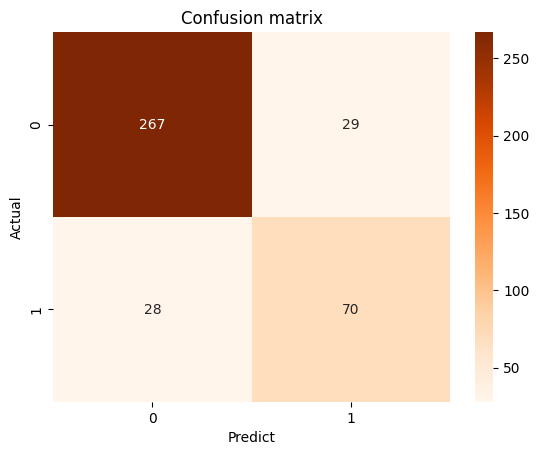

In [215]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrixx= confusion_matrix(y_test, y_pred_is)
sns.heatmap(confusion_matrixx, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [216]:
# بدون  pca

In [217]:
iso_for=IsolationForest(contamination=0.25,random_state=42)
y_pred_is_1=np.where(iso_for.fit_predict(X_test_1)==1,0,1)
print("Isolation_Forest")
print(f"Precision:{precision_score(y_test_1,y_pred_is_1)}")
print(f"Recall:{recall_score(y_test_1,y_pred_is_1)}")
print(f"F1-S:{f1_score(y_test_1,y_pred_is_1)}")
print(f"AUC-ROC:{roc_auc_score(y_test_1,y_pred_is_1)}")
print(classification_report(y_test_1,y_pred_is_1))
print("Co_M:")
print(confusion_matrix(y_test,y_pred_is_1))
print("Isolation_Forest")

Isolation_Forest
Precision:0.7070707070707071
Recall:0.7142857142857143
F1-S:0.7106598984771574
AUC-ROC:0.8081563706563707
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       296
           1       0.71      0.71      0.71        98

    accuracy                           0.86       394
   macro avg       0.81      0.81      0.81       394
weighted avg       0.86      0.86      0.86       394

Co_M:
[[267  29]
 [ 28  70]]
Isolation_Forest


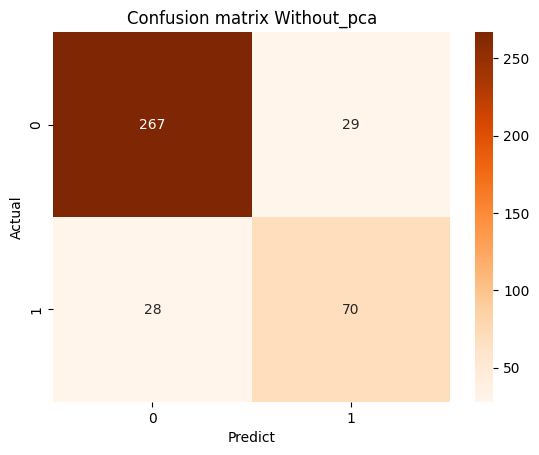

In [218]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrixx= confusion_matrix(y_test_1, y_pred_is)
sns.heatmap(confusion_matrixx, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion matrix Without_pca')
plt.show()

SVM Code

In [219]:
svm=OneClassSVM(nu=0.3,kernel='rbf',gamma='scale')
y_pred_sv=np.where(svm.fit_predict(X_test) == 1, 0, 1)
print("One-Class SVM")
print(f"Precision:{precision_score(y_test,y_pred_sv)}")
print(f"Recall:{recall_score(y_test,y_pred_sv)}")
print(f"F1-S:{f1_score(y_test,y_pred_sv)}")
print(f"AUC-ROC:{roc_auc_score(y_test,y_pred_sv)}")
print(classification_report(y_test,y_pred_sv))
print("Co_M:")
print(confusion_matrix(y_test,y_pred_sv))
print("Isolation Forest")

One-Class SVM
Precision:0.575
Recall:0.7040816326530612
F1-S:0.6330275229357798
AUC-ROC:0.765892167677882
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       296
           1       0.57      0.70      0.63        98

    accuracy                           0.80       394
   macro avg       0.73      0.77      0.75       394
weighted avg       0.81      0.80      0.80       394

Co_M:
[[245  51]
 [ 29  69]]
Isolation Forest


In [220]:
# "هنا استخدمت خوارزمية One-Class SVM لاكتشاف الشذوذ، وضبطت nu=0.3 لأنها تمثل نسبة الحالات الشاذة المتوقعة. بعد التدريب، قلبت القيم لأن النموذج يرجع -1 للشاذ و1 للعادي، وأنا أحتاج 1 للشاذ. بعدها حسبت مؤشرات الأداء مثل الدقة والاسترجاع والـ F1 والـ AUC، وطَبعت التقرير والمصفوفة للمقارنة مع Isolation Forest."

# "Here I used One-Class SVM for anomaly detection with nu=0.3, which represents the expected outlier ratio. I flipped the prediction values because the model returns -1 for anomalies and 1 for normal, but I need 1 for anomalies. Then I calculated performance metrics like Precision, Recall, F1, and AUC, and printed the report and confusion matrix to compare with Isolation Forest."



In [221]:
svm=OneClassSVM(nu=0.3,kernel='rbf',gamma='scale')
y_pred_sv_1=np.where(svm.fit_predict(X_test_1) == 1, 0, 1)
print("One-Class SVM")
print(f"Precision:{precision_score(y_test_1,y_pred_sv_1)}")
print(f"Recall:{recall_score(y_test_1,y_pred_sv_1)}")
print(f"F1-S:{f1_score(y_test_1,y_pred_sv_1)}")
print(f"AUC-ROC:{roc_auc_score(y_test_1,y_pred_sv_1)}")
print(classification_report(y_test_1,y_pred_sv_1))
print("Co_M:")
print(confusion_matrix(y_test_1,y_pred_sv_1))
print("Isolation Forest")

One-Class SVM
Precision:0.575
Recall:0.7040816326530612
F1-S:0.6330275229357798
AUC-ROC:0.765892167677882
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       296
           1       0.57      0.70      0.63        98

    accuracy                           0.80       394
   macro avg       0.73      0.77      0.75       394
weighted avg       0.81      0.80      0.80       394

Co_M:
[[245  51]
 [ 29  69]]
Isolation Forest


# **Random Forests Classifier**

In [222]:
# "في هذا الجزء استخدمت خوارزمية Random Forest للتصنيف. قسمت البيانات إلى تدريب واختبار بنسبة 80/20 مع توزيع متوازن حسب الفئة (stratify). بعد تدريب النموذج، توقعت القيم باستخدام predict، وحسّبت تقرير التصنيف وأيضًا AUC-ROC باستخدام predict_proba للحصول على احتمالية الانتماء للفئة الإيجابية."
# "In this part, I used the Random Forest classifier. I split the data into training and testing sets with an 80/20 ratio using stratified sampling. After training the model, I predicted the labels using predict and evaluated the performance using the classification report and AUC-ROC, where I used predict_proba to get the probability of the positive class."



In [223]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
clf=RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC-ROC:",roc_auc_score(y_test,clf.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       296
           1       1.00      1.00      1.00        98

    accuracy                           1.00       394
   macro avg       1.00      1.00      1.00       394
weighted avg       1.00      1.00      1.00       394

AUC-ROC: 1.0
